In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing

import gradient
import dataset
import computations
import layer
#from layer import Linear, Softmax, Gradient
import network

import datetime
import time

In [2]:
np.random.seed(400)
np.seterr(over='raise');
plt.rcParams['figure.figsize'] = (15.0, 5.0)

In [3]:
network1 = network.Network()
cifar = dataset.CIFAR_IMAGES()
#asgn1.test_batch_images(cifar_batch1)

In [4]:
#### Exercise - 4 ###
# Read in the data & initialize the parameters of the network
# TRAIN = 45.000 - VALIDATION = 5.000  ... TEST = 10.000
filePathLocal_labels = 'Dataset/batches.meta'
#filePathLocal_data_TRAIN = 'Dataset/data_batch_1'
#filePathLocal_data_VALIDATION = 'Dataset/data_batch_2'
filePathLocal_data_ALL = ['Dataset/data_batch_1', 'Dataset/data_batch_2', 'Dataset/data_batch_3', 'Dataset/data_batch_4', 'Dataset/data_batch_5']
filePathLocal_data_TEST = 'Dataset/test_batch'

filePathList = (filePathLocal_data_ALL, filePathLocal_data_TEST)

# Read TRAIN, VALIDATION, TEST data into numpy arrays (numpy.ndarray) from local files
network1.ReadData_Exercise4(cifar, filePathList)
# X = (d, N), Y = (K, N), y = (N,)   # N=number of total images in X
# X = (3072, 10000), Y = (10, 10000), y = (10000,)

# Find the MEAN and STD of trainX and broadcast them for matrix calculations
# trainX_Broadcast_MeanStd = (mean_train_X_broadcast, std_train_X_broadcast)
#trainX_Broadcast_MeanStd = network1.MeanStd_Train_X(network1.train_X)

# MEL
# Transform the INPUT to have zero mean ** Check that one if we need to transfer all of them separately or
# only having the normalization as in here??
# Normalize all INPUT data by using MEAN and STD of TRAIN DATA
'''
train_X_Norm = network1.NormalizeData(network1.train_X, trainX_Broadcast_MeanStd)
validation_X_Norm = network1.NormalizeData(network1.validation_X, trainX_Broadcast_MeanStd)
test_X_Norm = network1.NormalizeData(network1.test_X, trainX_Broadcast_MeanStd)
'''

train_X_Norm = network1.NormalizeData_Broadcast(network1.train_X, network1.train_X)
#validation_X_Norm = network1.NormalizeData_Broadcast(network1.validation_X, network1.train_X)
validation_X_Norm = network1.NormalizeData_Per_DataSet(network1.validation_X)
#test_X_Norm = network1.NormalizeData_Broadcast(network1.test_X, network1.train_X)
test_X_Norm = network1.NormalizeData_Per_DataSet(network1.test_X)

# mu = 0; d = network1.train_X.shape[0]; m = 50; K = network1.train_Y.shape[0]
# we will use only 20 of 3072 to have a dimension reduction in comparing grad_analytic and grad_Numerical
#mu = 0; d = 20; m = 50; K = network1.train_Y.shape[0]
mu = 0; d = network1.train_X.shape[0]; m = 50; K = network1.train_Y.shape[0]

initial_sizes = (mu, d, m, K)

sigma1 = 1 / int(np.sqrt(d))
sigma2 = 1 / np.sqrt(m)

# Generate W1, W2, b1, b2 matrices with initial values
#(W1, W2, b1, b2) = network1.Initialize_W_b(d, m, K, sigma1, sigma2)
(W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)
# W1 = (50, 3072), W2 = (10, 50), b1 = (50, 1), b2 = (10, 1) # if we use the whole dimensions/features
# W1 = (50, 20), W2 = (10, 50), b1 = (50, 1), b2 = (10, 1) # if we use 20 dimensions/features
# W1 = (m, d), W2 = (K, m), b1 = (m, 1), b2 = (K, 1)

In [5]:
'''
print("Mean-STD:\n trainX_Broadcast_MeanStd[0]=\n{}\n\ntrainX_Broadcast_MeanStd[1]=\n{}".\
      format(trainX_Broadcast_MeanStd[0], trainX_Broadcast_MeanStd[1]))
print("\n\nMean-STD:\n train_X_Norm.mean(axis=1)={}\n\n".format(train_X_Norm.mean(axis=1)))
'''
print("Shape check:\n train_X_Norm={}\t validation_X_Norm={}\t test_X_Norm={}".format(train_X_Norm.shape, validation_X_Norm.shape, test_X_Norm.shape))
print(" train_Y={}\t\t validation_Y={}\t\t test_Y={}".format(network1.train_Y.shape, network1.validation_Y.shape, network1.test_Y.shape))
print(" train_y={}\t\t validation_y={}\t\t\t test_y={}".format(network1.train_y.shape, network1.validation_y.shape, network1.test_y.shape))
print(" W1={}\t\t\t W2={}\t\t\t\t b1={}\t\t\t b2={}".format(W1.shape, W2.shape, b1.shape, b2.shape))

Shape check:
 train_X_Norm=(3072, 45000)	 validation_X_Norm=(3072, 5000)	 test_X_Norm=(3072, 10000)
 train_Y=(10, 45000)		 validation_Y=(10, 5000)		 test_Y=(10, 10000)
 train_y=(45000,)		 validation_y=(5000,)			 test_y=(10000,)
 W1=(50, 3072)			 W2=(10, 50)				 b1=(50, 1)			 b2=(10, 1)


In [6]:
#def Plot_Train_Validation_Cost_Accurracy(self, Cost_Train, Cost_Validation, Acc_Train, Acc_Validation):
def Plot_Train_Validation_Cost_Accurracy(Cost_Train, Cost_Validation, Acc_Train, Acc_Validation, Eta):
        plt.subplot(1,3,1)
        plt.plot(Cost_Train, 'g-', label='Train')
        plt.plot(Cost_Validation, 'r-', label='Validation')
        plt.title('Cost Comparison')
        plt.xlabel('n_records')
        plt.ylabel('Cost')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,3,2)
        plt.plot(Acc_Train, 'g-', label='Train')
        plt.plot(Acc_Validation, 'r-', label='Validation')
        plt.title('Accuracy Comparison')
        plt.xlabel('n_records')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,3,3)
        plt.plot(Eta, 'g-', label='Eta')
        plt.title('Eta Change')
        plt.xlabel('Time')
        plt.ylabel('Eta')
        plt.legend()
        plt.grid('on')

In [7]:
def Coarse_Search(l_min, l_max):
    l = l_min + (l_max - l_min) * np.random.uniform(0,1)
    lambda_coarse = pow(10, l)
    return lambda_coarse

In [8]:
# this function uses the BATCH data with a SMOOTH_COST to calculate the ACCURACY & COST
def Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list):
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m,
    #                eta_min, eta_max]
    '''
    Up until now, we have trained our networks with Vanilla mini-batch gradient descent. 
    To help speed up training times and avoid time-consuming searches for good values of eta, we will now
    implement mini-batch-GD training where the learning rate at each update step is defined in a cylical way
    check equations (14) and (15) in the assignment.
    '''
    network1 = param_list[0]
    train_X_Norm = param_list[1]      # 45.000 images
    validation_X_Norm = param_list[2] # 5.000 images
    # the size of a mini-batch. in other words, number of images in 1 mini-batch
    batch_size = param_list[3]        # 100
    # number of triangles that you want to use to test different eta values
    n_cycles = param_list[4]         # 1
    # regularization coefficient (punishment)
    lambda_cost = param_list[5]      # 0.01
    # how many calculations do you want to see per cycle? = 10? 20? 30? to plot the graph
    # record_per_cycle = 100  (+1 is to show the first calculation, as well)
    record_per_cycle = param_list[6]
 
    d = train_X_Norm.shape[0]       # dimension of X_train... 3072 = 32 x 32 x 3
    m = param_list[7]               # number of nodes in the hidden layer... 50
    K = network1.train_Y.shape[0]  # number of classes... 10
    eta_min = param_list[8] # learning rate (step-size)   i.e. 1e-5 
    eta_max = param_list[9] # learning rate (step-size)   i.e. 1e-1  

    # Generate W1, W2, b1, b2 matrices with initial values
    sigma1 = 1 / int(np.sqrt(d))   # std to initialize W1
    sigma2 = 1 / np.sqrt(m)        # std to initialize W2
    #(W1, W2, b1, b2) = network1.Initialize_W_b([mu, d, m, K], sigma1, sigma2)
    initial_sizes = [0, d, m, K]
    (W1, W2, b1, b2) = network1.Initialize_W_b(initial_sizes, sigma1, sigma2)

    W = [W1, W2]
    b = [b1, b2]

    linearLayer1 = layer.Linear()
    reluLayer = layer.ReLU()             # not an exact layer but operational step..
    linearLayer2 = layer.Linear()
    softmaxLayer = layer.Softmax()       # not an exact layer but operational step..
    ReLUlayer = layer.ReLU()
    grad = gradient.Gradient()

    layers = [linearLayer1, reluLayer, linearLayer2, softmaxLayer]
    # total_batch = how many mini-batches will we need to cover the entire training set
    # we will use 45000 images for training = train_X_Norm.shape[1]
    # total_batch = 45000/100 = 450
    #total_batch = int(np.ceil(train_X_Norm.shape[1] / batch_size))
    total_batch = int(np.floor(train_X_Norm.shape[1] / batch_size))
    
    # A full cycle: once goes up (from eta_min to eta_max) and once goes down (from eta_max to eta_min)
    # so we multiply by 2    
    n_steps = 2 * total_batch  # 2 * 450 = 900      # this was given by definition in the assignment
    # n_steps / total_batch = 2 is picked (before, this value was used as k in exercise-3)
    # but in exercise-3, we were given the n_steps, now, n_steps is calculated by the above equation and 
    # k is given as 2 according to the equation
    ##### n_epochs = int(2 * n_cycles * (n_steps / total_batch))
    # k=2 is accepted as in this formula n_s = k[n/n_batch] ... 1 cycle= 2 * n_s
    # n_epochs = 2 * k * n_cycles = 2 * 2 * 1 = 4 in the first example
    n_epochs = 2 * 2 * n_cycles
    
    # !!!! CAUTION !!!! the usage of n_records and t is different than the previous functions - Do not confuse!
    n_records = total_batch * n_epochs   # number of batches will be used IN TOTAL for ALL calculations
    # i.e. 450 * 4 = 1800 
    
    # how many points in total we will have in the COST graph
    cost_record = record_per_cycle * n_cycles + 1  # 100 * 1 + 1 = 101
    ###comparison_number = total_batch/cost_record  
    # to be able to have that many points, at which batch we should run the COST functions (e.g. in every 18 batch)
    comparison_number = int(n_records / (cost_record - 1))  # 1800/100 = 18
    
    eta_train = np.zeros(n_records)              # we will check if we properly make a triangle
    
    J_epocs_train = np.zeros(cost_record)        # cost array to plot and see how cost changes
    Accuracy_epocs_train = np.zeros(cost_record) # accuracy array
    J_epocs_validation = np.zeros(cost_record) 
    Accuracy_epocs_validation = np.zeros(cost_record) 
    
    print('batch_size: {}, lambda_cost : {}, d: {}, m: {}, K: {}'.format(batch_size, lambda_cost, d, m, K))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}, cost_record: {}'.format(total_batch, n_steps, n_epochs, n_records, cost_record))
    print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}'.format(total_batch, n_steps, n_epochs, 
                                                                                n_records))
    print('\nrecord_per_cycle: {}, cost_record : {}, comparison_number: {}'.format(record_per_cycle, cost_record, 
                                                                                   comparison_number))
  
    # cycleID in use.. if n_cycles=0 then cycle max will be 0. else it will be incremented by 1 at each 2*n_steps
    cycle_no = 0
    J_train_sum = 0
    n_records = 0       # this will basically show the number of batches processed until now
    list_params = []
    smooth_cost = 0
    cost_record = 0
    # step number in the current cycle, it resets with a new cycle. 
    cycle_step = 0   # just to see where we are in the current triangle
    
    start_time = datetime.datetime.now()
    for e in range(n_epochs):
        for batch in range(total_batch):
            index_list = list(range(batch * batch_size, (batch + 1) * batch_size))
            # shuffling is not necessary but good to have
            np.random.shuffle(index_list)
            X_batch = train_X_Norm[:, index_list]
            Y_batch = network1.train_Y[:, index_list]

            P, H = network1.EvaluationClassifier(layers, X_batch, W, b)

            G2 = -np.subtract(Y_batch, P)  # 
            N2 = Y_batch.shape[1]          # 

            (grad_W2, grad_b2, G1) = grad.ComputeGradients_Linear_HiddenLayer(N2, G2, H, lambda_cost, W2) 
            G0 = reluLayer.Backward(G1, H)
            N1 = H.shape[1]                # 

            (grad_W1, grad_b1) = grad.ComputeGradients_Linear_FirstLayer(N1, G0, X_batch, lambda_cost, W1)
            
            # n_cycles = 1   # corresponds to "L array" in 2.L.ns in the assignment .. 
            # L=the current cycle number ... n_cycles=the total number of cycles to be applied
            # so L is an element of n_cycle >> i.e. L = {0, 1, 2, 3} if n_cycles = 4 
            #if 2*cycle_no*n_steps <= t and t <= (2*cycle_no+1)*n_steps:
            # n_records corresponds to t in the formula
            if 2*cycle_no*n_steps <= n_records and n_records <= (2*cycle_no+1)*n_steps:
                #eta = eta_min + (t - 2*cycle_no*n_steps)/n_steps*(eta_max-eta_min)
                eta = eta_min + (n_records - 2*cycle_no*n_steps)/n_steps*(eta_max-eta_min)
            #elif (2*cycle_no+1)*n_steps <= t and t <= 2*(cycle_no+1)*n_steps:
            elif (2*cycle_no+1)*n_steps <= n_records and n_records <= 2*(cycle_no+1)*n_steps:
                #eta = eta_max - (t - (2*cycle_no+1)*n_steps)/n_steps*(eta_max-eta_min)
                eta = eta_max - (n_records - (2*cycle_no+1)*n_steps)/n_steps*(eta_max-eta_min)
            
            eta_train[n_records] = eta
            
            # W1star, W2star
            W1 = W1 - eta * grad_W1
            W2 = W2 - eta * grad_W2

            # b1star, b2star
            bstar_m1 = b1 - eta * grad_b1
            b1 = bstar_m1[:, :1]  # there's a broadcast issue needs to be fixed, that's why we pick only 1 column

            bstar_m2 = b2 - eta * grad_b2
            b2 = bstar_m2[:, :1]  # broadcast issue, this is a quick workaround - use 1 column
            
            W = [W1, W2]
            b = [b1, b2]

            #if n_records % 10 == 0:
            if n_records == 0 or (n_records + 1) % comparison_number == 0:
                print('\nepoch: {}, batch: {}, n_records: {}, cycle_step: {}'.format(e, batch, n_records, cycle_step))

                J_train = network1.Cost(X_batch, Y_batch, W, b, lambda_cost)
                J_train_sum += J_train
                smooth_cost = J_train_sum/(cost_record + 1)
                #J_epocs_train[n_records] = J_train
                J_epocs_train[cost_record] = smooth_cost

                ## If we use the ALL TRAINING data to calculate the training accuracy:
                # it feels like better to use that one
                P, H = network1.EvaluationClassifier(layers, train_X_Norm, W, b)
                k_train = np.argmax(P, axis=0)
                A_train = network1.ComputeAccuracy(k_train, network1.train_y)
                Accuracy_epocs_train[cost_record] = A_train

                J_validation = network1.Cost(validation_X_Norm , network1.validation_Y, W, b, lambda_cost)
                J_epocs_validation[cost_record] = J_validation

                P_val, H_val = network1.EvaluationClassifier(layers, validation_X_Norm, W, b)
                k_validation = np.argmax(P_val, axis=0)
                A_validation = network1.ComputeAccuracy(k_validation, network1.validation_y)
                Accuracy_epocs_validation[cost_record] = A_validation
                
                cost_record += 1
                
                print('cycle_no: {} ... eta: {} ... time: {}'.format(cycle_no, eta, datetime.datetime.now()))
                print('J_train: {} ... smooth_cost : {} ... J_validation: {}'.format(J_train, smooth_cost, J_validation))
                #print('\neta: {}, cycle_step: {}'.format(eta, cycle_step))
            
            #if n_records == 0 or (n_records+1) % 100 == 0:
             #   print('\ncycle_no: {}, epoch: {}, batch: {}, n_records: {}, cycle_step: {}'.format(cycle_no, e, batch, n_records, cycle_step))                
                           
            n_records += 1
            cycle_step += 1
            
            #if t % (2 * n_steps) == 0:
            if n_records % (2 * n_steps) == 0:
                cycle_no += 1
                cycle_step = 0

    end_time = datetime.datetime.now()
    
    print("Calculation time of Train_Cyclical: " + str(end_time - start_time))
    print("x-axis (steps) must be multiplied by 10 since the values recorded once in every 10 Cycle")
    
    Plot_Train_Validation_Cost_Accurracy(J_epocs_train, J_epocs_validation, Accuracy_epocs_train, 
                                         Accuracy_epocs_validation, eta_train)
    print('batch_size: {}, lambda_cost : {}, d: {}, m: {}, K: {}'.format(batch_size, lambda_cost, d, m, K))
    #print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}, cost_record: {}'.format(total_batch, n_steps, n_epochs, n_records, cost_record))
    print('\ntotal_batch: {}, n_steps : {}, n_epochs: {}, n_records: {}'.format(total_batch, n_steps, 
                                                                                n_epochs, n_records))
    print('\nrecord_per_cycle: {}, cost_record : {}, comparison_number: {}'.format(record_per_cycle, 
                                                                                   cost_record, comparison_number))
    return layers, W, b, eta_train

batch_size: 100, lambda_cost : 0.01, d: 3072, m: 50, K: 10

total_batch: 450, n_steps : 900, n_epochs: 4, n_records: 1800

record_per_cycle: 100, cost_record : 101, comparison_number: 18

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:34:56.110229
J_train: 3.2277118727885625 ... smooth_cost : 3.2277118727885625 ... J_validation: 3.224197643145205

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:34:56.488240
J_train: 3.084017154342685 ... smooth_cost : 3.155864513565624 ... J_validation: 3.0779757101439684

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:34:56.880885
J_train: 2.7922282041393043 ... smooth_cost : 3.0346524104235173 ... J_validation: 2.884412629624818

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:34:57.284282
J_

cycle_no: 0 ... eta: 0.0698919 ... time: 2020-08-19 23:35:10.351259
J_train: 1.5789034156611668 ... smooth_cost : 2.0380509413011385 ... J_validation: 1.9696648060990773

epoch: 1, batch: 197, n_records: 647, cycle_step: 647
cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:35:10.766305
J_train: 1.6365662729434556 ... smooth_cost : 2.0272000043184986 ... J_validation: 1.9224785107515707

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:35:11.194229
J_train: 1.4729882551378215 ... smooth_cost : 2.012615484603218 ... J_validation: 1.9008725270007871

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:35:11.594388
J_train: 1.3500693396295427 ... smooth_cost : 1.9956271219115849 ... J_validation: 1.8929471535383842

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:35:12.025151
J_train: 1.504917458896

cycle_no: 0 ... eta: 0.0581153 ... time: 2020-08-19 23:35:25.438678
J_train: 1.5444860155919242 ... smooth_cost : 1.739273942089059 ... J_validation: 1.6918169931890716

epoch: 2, batch: 395, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:35:25.853166
J_train: 1.3953335258410675 ... smooth_cost : 1.7345624295377169 ... J_validation: 1.6775150845698956

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:35:26.275669
J_train: 1.4485086554267874 ... smooth_cost : 1.7306968379956773 ... J_validation: 1.6767499742881975

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:35:26.696636
J_train: 1.3722021971278051 ... smooth_cost : 1.725916909450772 ... J_validation: 1.6852530516535398

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:35:27.116305
J_tra

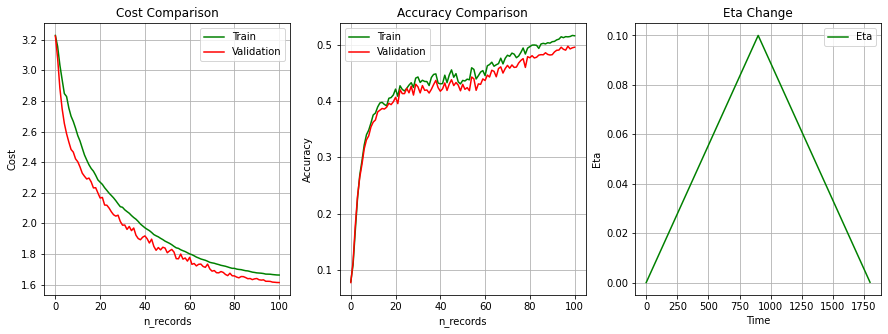

In [11]:
# In this function, we didn't calculate the cost for each batch but we calculated it for 100 batches out of 1800 
# in 1 cycle and this helped us to save a lot of time with a similar result with the one I calculated J for 
# each batch
# takes ONLY around 40 seconds!
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]
param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, 0.01, 100, 50, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)


In [13]:
print('Eta_Train\nmin: {}\tmax: {}\tmean: {}\tmedian: {}\nstd: {}\tvar: {}'.format(min(eta_train), 
        max(eta_train), np.mean(eta_train), np.median(eta_train), np.std(eta_train), np.var(eta_train)))

Eta_Train
min: 1e-05	max: 0.1	mean: 0.050005	median: 0.05000500000000001
std: 0.028864662343454958	var: 0.0008331687322016667


In [12]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4938


batch_size: 100, lambda_cost : 0.003772863865559457, d: 3072, m: 50, K: 10

total_batch: 450, n_steps : 900, n_epochs: 4, n_records: 1800

record_per_cycle: 100, cost_record : 101, comparison_number: 18

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:39:55.630431
J_train: 2.6445211654888885 ... smooth_cost : 2.6445211654888885 ... J_validation: 2.8199099008231037

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:39:56.022713
J_train: 2.7017788229519835 ... smooth_cost : 2.673149994220436 ... J_validation: 2.6589210835573795

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:39:56.417844
J_train: 2.360582689534298 ... smooth_cost : 2.56896089265839 ... J_validation: 2.453194123441711

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:

cycle_no: 0 ... eta: 0.0698919 ... time: 2020-08-19 23:40:10.851753
J_train: 1.3927963482948074 ... smooth_cost : 1.7463056722475807 ... J_validation: 1.8345594907888685

epoch: 1, batch: 197, n_records: 647, cycle_step: 647
cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:40:11.304533
J_train: 1.4753214336624914 ... smooth_cost : 1.738981773907443 ... J_validation: 1.821099564525451

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:40:11.757955
J_train: 1.2974563749768944 ... smooth_cost : 1.727362684461902 ... J_validation: 1.7773871044829062

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:40:12.239699
J_train: 1.2405471524884972 ... smooth_cost : 1.7148802349241226 ... J_validation: 1.7817795716543858

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:40:12.739592
J_train: 1.37765050181601

cycle_no: 0 ... eta: 0.0581153 ... time: 2020-08-19 23:40:26.275673
J_train: 1.5095624331190345 ... smooth_cost : 1.5436674851551277 ... J_validation: 1.658089784597402

epoch: 2, batch: 395, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:40:26.697522
J_train: 1.3298753521473548 ... smooth_cost : 1.5407388257988568 ... J_validation: 1.6386530064692288

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:40:27.114705
J_train: 1.3649371504552725 ... smooth_cost : 1.538363127483403 ... J_validation: 1.6359107966750384

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:40:27.531080
J_train: 1.2304836019624392 ... smooth_cost : 1.5342580671431234 ... J_validation: 1.6509835514251616

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:40:27.962454
J_tra

cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:40:40.392937
J_train: 1.9510993635711948 ... smooth_cost : 2.2057717126315812 ... J_validation: 2.145180522534711

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:40:40.812022
J_train: 1.9099189089006638 ... smooth_cost : 2.146601151885398 ... J_validation: 2.066964979450784

epoch: 0, batch: 89, n_records: 89, cycle_step: 89
cycle_no: 0 ... eta: 0.009897900000000001 ... time: 2020-08-19 23:40:41.228628
J_train: 2.027491618305776 ... smooth_cost : 2.1267495629554607 ... J_validation: 1.9989116450309181

epoch: 0, batch: 107, n_records: 107, cycle_step: 107
cycle_no: 0 ... eta: 0.0118977 ... time: 2020-08-19 23:40:41.651285
J_train: 1.754789653523597 ... smooth_cost : 2.0736124330366232 ... J_validation: 1.954329143817609

epoch: 0, batch: 125, n_records: 125, cycle_step: 125
cycle_no: 0 ... eta: 0.013897500000000002 ... time: 2020-08-19 23:40:42.068492
J_train: 1

cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:40:55.554473
J_train: 1.2225939953645968 ... smooth_cost : 1.4915163124328328 ... J_validation: 1.6443196093386416

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:40:55.977078
J_train: 1.205034166856674 ... smooth_cost : 1.4845289430285362 ... J_validation: 1.6690048647017393

epoch: 1, batch: 287, n_records: 737, cycle_step: 737
cycle_no: 0 ... eta: 0.08189070000000001 ... time: 2020-08-19 23:40:56.396631
J_train: 1.2917863762018136 ... smooth_cost : 1.4799398342945667 ... J_validation: 1.6629821777679337

epoch: 1, batch: 305, n_records: 755, cycle_step: 755
cycle_no: 0 ... eta: 0.0838905 ... time: 2020-08-19 23:40:56.817552
J_train: 1.2390231161236827 ... smooth_cost : 1.4743371199184996 ... J_validation: 1.6688216265940865

epoch: 1, batch: 323, n_records: 773, cycle_step: 773
cycle_no: 0 ... eta: 0.0858903 ... time: 2020-08-19 23:40:57.234703
J_train: 1.210716046337

cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:41:10.814175
J_train: 1.2570432577632102 ... smooth_cost : 1.3500108859909274 ... J_validation: 1.5367857506320983

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:41:11.283291
J_train: 1.2775005497610268 ... smooth_cost : 1.349069193312617 ... J_validation: 1.5222847706838905

epoch: 3, batch: 35, n_records: 1385, cycle_step: 1385
cycle_no: 0 ... eta: 0.046116500000000005 ... time: 2020-08-19 23:41:11.769489
J_train: 1.1652867162160736 ... smooth_cost : 1.3467130077088152 ... J_validation: 1.5119857380013015

epoch: 3, batch: 53, n_records: 1403, cycle_step: 1403
cycle_no: 0 ... eta: 0.0441167 ... time: 2020-08-19 23:41:12.268555
J_train: 1.0500240179566542 ... smooth_cost : 1.3429574508765094 ... J_validation: 1.5373808661873458

epoch: 3, batch: 71, n_records: 1421, cycle_step: 1421
cycle_no: 0 ... eta: 0.0421169 ... time: 2020-08-19 23:41:12.7855

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:41:26.324933
J_train: 2.864771258387959 ... smooth_cost : 2.864771258387959 ... J_validation: 2.806712074761112

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:41:26.830379
J_train: 2.67405177627742 ... smooth_cost : 2.7694115173326894 ... J_validation: 2.6546056559468716

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:41:27.331852
J_train: 2.3783115210608967 ... smooth_cost : 2.6390448519087584 ... J_validation: 2.4718414622724865

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:41:27.820945
J_train: 2.170300473605394 ... smooth_cost : 2.521858757332917 ... J_validation: 2.3469368618535746

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:41:28.297632
J_train: 2.10682751

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:41:42.830575
J_train: 1.432318045437735 ... smooth_cost : 1.7111696705795676 ... J_validation: 1.7942960542544715

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:41:43.320878
J_train: 1.2812179731430746 ... smooth_cost : 1.699855152225976 ... J_validation: 1.7637767089408392

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:41:43.833871
J_train: 1.1798645638311276 ... smooth_cost : 1.6865220602158517 ... J_validation: 1.7605547585033283

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:41:44.317786
J_train: 1.36089558837591 ... smooth_cost : 1.678381398419853 ... J_validation: 1.7805863627380947

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:41:44.799132
J_train: 1.338392991716946 

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:41:59.751295
J_train: 1.2828146812135506 ... smooth_cost : 1.5169478868492425 ... J_validation: 1.6318408060294953

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:42:00.190765
J_train: 1.3339792605934233 ... smooth_cost : 1.5144753378457856 ... J_validation: 1.6245794752686278

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:42:00.641289
J_train: 1.2461877613759895 ... smooth_cost : 1.5108981701595217 ... J_validation: 1.646767489465038

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:42:01.100989
J_train: 1.3868662741068367 ... smooth_cost : 1.5092661715272495 ... J_validation: 1.632391026682244

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:42:01.541

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:42:12.692250
J_train: 2.5118355327173925 ... smooth_cost : 2.5118355327173925 ... J_validation: 2.624322013076691

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:42:13.149915
J_train: 2.5297860260594454 ... smooth_cost : 2.5208107793884187 ... J_validation: 2.490806233254362

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:42:13.593391
J_train: 2.2099567168876417 ... smooth_cost : 2.4171927585548265 ... J_validation: 2.3199624002110877

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:42:14.046844
J_train: 2.0876875236203594 ... smooth_cost : 2.3348164498212096 ... J_validation: 2.207548629250521

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:42:14.490186
J_train: 1.9347

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:42:28.374146
J_train: 1.3372564023578608 ... smooth_cost : 1.5725554505306432 ... J_validation: 1.7231143266627906

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:42:28.818204
J_train: 1.1696979565720234 ... smooth_cost : 1.5619539375317322 ... J_validation: 1.6847690761988876

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:42:29.250974
J_train: 1.0838761949308384 ... smooth_cost : 1.549695533875299 ... J_validation: 1.689939897421033

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:42:29.684588
J_train: 1.215903277969955 ... smooth_cost : 1.5413507274776654 ... J_validation: 1.6985989138941484

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:42:30.119436
J_train: 1.22928693080615

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:42:44.112551
J_train: 1.2171485395066073 ... smooth_cost : 1.4026838214928967 ... J_validation: 1.5618227733648449

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:42:44.541718
J_train: 1.256206428634839 ... smooth_cost : 1.4007043972650852 ... J_validation: 1.5531077284907335

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:42:44.964332
J_train: 1.193847963410894 ... smooth_cost : 1.3979463114803625 ... J_validation: 1.588866081501941

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:42:45.390922
J_train: 1.3365800057423116 ... smooth_cost : 1.3971388600890724 ... J_validation: 1.5642463445594796

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:42:45.8146

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:42:56.634363
J_train: 3.5062632871027306 ... smooth_cost : 3.5062632871027306 ... J_validation: 3.5056799272156107

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:42:57.065723
J_train: 3.414914929990803 ... smooth_cost : 3.460589108546767 ... J_validation: 3.414711915265581

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:42:57.498377
J_train: 3.188772815968566 ... smooth_cost : 3.3699836776873666 ... J_validation: 3.2922988778944275

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:42:57.931849
J_train: 3.1130024135609355 ... smooth_cost : 3.3057383616557585 ... J_validation: 3.198311455425417

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:42:58.364332
J_train: 3.009024

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:43:12.178017
J_train: 1.6936223898377234 ... smooth_cost : 2.2996627241702994 ... J_validation: 1.958365883399892

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:43:12.613974
J_train: 1.5285685674692182 ... smooth_cost : 2.2793707726781656 ... J_validation: 1.9213872650245878

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:43:13.045872
J_train: 1.4521932457764923 ... smooth_cost : 2.2581610925012 ... J_validation: 1.9056338442987781

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:43:13.467527
J_train: 1.535403898377425 ... smooth_cost : 2.2400921626481054 ... J_validation: 1.9103411967833241

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:43:13.886132
J_train: 1.5188486023808188

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:43:27.998282
J_train: 1.4897270177115791 ... smooth_cost : 1.9041360898025272 ... J_validation: 1.7281720525068767

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:43:28.428351
J_train: 1.5400657038460914 ... smooth_cost : 1.8992162197220348 ... J_validation: 1.7239522347846583

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:43:28.856938
J_train: 1.4676279034715247 ... smooth_cost : 1.893461708838695 ... J_validation: 1.7367412426417905

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:43:29.276908
J_train: 1.5563552233761146 ... smooth_cost : 1.8890260971878714 ... J_validation: 1.7377572902112735

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:43:29.68

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:43:40.350525
J_train: 2.4753750687809237 ... smooth_cost : 2.4753750687809237 ... J_validation: 2.5418947989258585

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:43:40.790393
J_train: 2.4075925229987334 ... smooth_cost : 2.4414837958898286 ... J_validation: 2.4326319699229892

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:43:41.228933
J_train: 2.1576472566965577 ... smooth_cost : 2.3468716161587384 ... J_validation: 2.2832289571274162

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:43:41.666741
J_train: 2.060832775790992 ... smooth_cost : 2.2753619060668018 ... J_validation: 2.1813917379799252

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:43:42.111100
J_train: 1.98

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:43:55.864343
J_train: 1.3501967363524545 ... smooth_cost : 1.5617038157832779 ... J_validation: 1.673184106370884

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:43:56.292388
J_train: 1.1454978793709234 ... smooth_cost : 1.5507510279829528 ... J_validation: 1.675109527349743

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:43:56.712158
J_train: 1.0626096481786738 ... smooth_cost : 1.5382345823469454 ... J_validation: 1.6430409354969016

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:43:57.128938
J_train: 1.2174948829432477 ... smooth_cost : 1.530216089861853 ... J_validation: 1.6809492185099437

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:43:57.544931
J_train: 1.17113335866761

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:44:11.455494
J_train: 1.130657093438086 ... smooth_cost : 1.3800958193397341 ... J_validation: 1.5486991880632746

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:44:11.889047
J_train: 1.215368054955966 ... smooth_cost : 1.377869768469683 ... J_validation: 1.54663929351916

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:44:12.315225
J_train: 1.096319299665744 ... smooth_cost : 1.374115762218964 ... J_validation: 1.553099076845468

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:44:12.741160
J_train: 1.3312216244506312 ... smooth_cost : 1.3735513656693807 ... J_validation: 1.5379556277331745

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:44:13.168023
J_

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:44:23.718422
J_train: 2.566469180643306 ... smooth_cost : 2.566469180643306 ... J_validation: 2.563242566072652

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:44:24.152370
J_train: 2.3803792171057285 ... smooth_cost : 2.4734241988745174 ... J_validation: 2.4457635272668785

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:44:24.574739
J_train: 2.2074758571559836 ... smooth_cost : 2.3847747516350064 ... J_validation: 2.272085211480347

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:44:24.998211
J_train: 2.0969588860981725 ... smooth_cost : 2.312820785250798 ... J_validation: 2.1549353458395917

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:44:25.423152
J_train: 1.856641

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:44:39.277809
J_train: 1.2345769713216956 ... smooth_cost : 1.5088575881709794 ... J_validation: 1.6325290587895107

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:44:39.714746
J_train: 1.0881077119508535 ... smooth_cost : 1.4977852230072919 ... J_validation: 1.6217504324741827

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:44:40.138063
J_train: 1.0112336880963702 ... smooth_cost : 1.4853095426249605 ... J_validation: 1.6247239967577591

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:44:40.554827
J_train: 1.1522872695871387 ... smooth_cost : 1.476983985799015 ... J_validation: 1.654601518823289

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:44:40.973483
J_train: 1.1295211803459

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:44:54.820069
J_train: 1.1202952456150996 ... smooth_cost : 1.3298799590703276 ... J_validation: 1.5125345850094167

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:44:55.266890
J_train: 1.1291351112947379 ... smooth_cost : 1.327167190857144 ... J_validation: 1.5054162687152766

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:44:55.714882
J_train: 1.059543257199073 ... smooth_cost : 1.3235988717417029 ... J_validation: 1.5149360180140905

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:44:56.157151
J_train: 1.217818801885535 ... smooth_cost : 1.3222070287172796 ... J_validation: 1.500990577037141

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:44:56.59485

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:45:07.198458
J_train: 2.5121833862174676 ... smooth_cost : 2.5121833862174676 ... J_validation: 2.4644505604685856

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:45:07.621834
J_train: 2.309072770084499 ... smooth_cost : 2.4106280781509835 ... J_validation: 2.3418870032394583

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:45:08.043506
J_train: 2.056041865270508 ... smooth_cost : 2.292432673857492 ... J_validation: 2.193768736340285

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:45:08.461484
J_train: 1.909002326415342 ... smooth_cost : 2.1965750869969543 ... J_validation: 2.100010955838013

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:45:08.884128
J_train: 1.8838769

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:45:22.888957
J_train: 1.3170772332336858 ... smooth_cost : 1.498136126799159 ... J_validation: 1.6465869263407893

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:45:23.317865
J_train: 1.0691568676318304 ... smooth_cost : 1.4868471989263348 ... J_validation: 1.6192574673857805

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:45:23.736927
J_train: 0.9905381513657211 ... smooth_cost : 1.4741213259119599 ... J_validation: 1.6024223511540021

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:45:24.151969
J_train: 1.1610563666327645 ... smooth_cost : 1.46629470192998 ... J_validation: 1.629570636841392

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:45:24.578381
J_train: 1.153950033292004

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:45:38.194102
J_train: 1.1258737774568364 ... smooth_cost : 1.3273089468354953 ... J_validation: 1.5229501615198588

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:45:38.629357
J_train: 1.1899778924830005 ... smooth_cost : 1.3254531217766776 ... J_validation: 1.5205974189288014

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:45:39.064547
J_train: 1.0948148909330893 ... smooth_cost : 1.3223779453654299 ... J_validation: 1.5363637659387237

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:45:39.508922
J_train: 1.252024346390027 ... smooth_cost : 1.3214522401157536 ... J_validation: 1.518601647739834

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:45:39.977

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

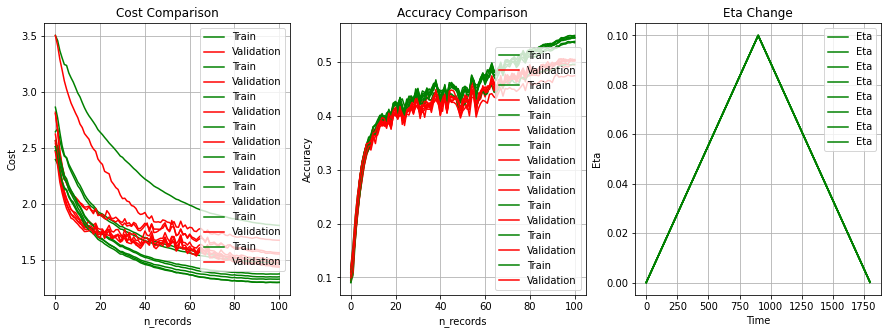

In [14]:
# takes around 5.5 minutes!! >> LIMIT the J (Cost) calculation per cycle instead
# of calculating J per batch
# this one uses the formula given in the assignment for the lambda_coarse values
lambda_coarse_list = []
#n_cycles = 1
#record_per_cycle = 100
start_time = datetime.datetime.now()
for i in range(8):
    lambda_coarse = Coarse_Search(-5, -1)
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m,
    #               eta_min, eta_max]
    param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, lambda_coarse, 100, 50, 1e-5, 1e-1]
    layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

    P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
    k_test = np.argmax(P_test, axis=0)
    A_test = network1.ComputeAccuracy(k_test, network1.test_y)
    #lambda_coarse_list.append([lambda_coarse, A_test, W, b])
    lambda_coarse_list.append([lambda_coarse, A_test])
    print(datetime.datetime.now())
    print('Test accuracy of {}. lambda ({})={}'.format(i, lambda_coarse, A_test))
    
end_time = datetime.datetime.now()
print("Calculation time of lambda_coarse: " + str(end_time - start_time))

In [15]:
# [lambda, test_accuracy]
lambda_coarse_list

[[0.003772863865559457, 0.499],
 [0.0004930704361181606, 0.4996],
 [0.0033665965785468826, 0.4975],
 [0.001305094636607304, 0.5022],
 [0.01757893078506135, 0.4828],
 [0.0007012053067447107, 0.499],
 [9.177497906795191e-05, 0.502],
 [0.000310949509136683, 0.4969]]

In [9]:
import fileinput

def Time_Stamp():
    date_time = datetime.datetime.now()
    
    D = str(date_time.day)
    M = str(date_time.month)
    Y = str(date_time.year)

    h = str(date_time.hour)
    m = str(date_time.minute)
    s = str(date_time.second)
    
    date_array = [D, M, Y, h, m, s]
    
    return date_array
    
def FileNameUnique(prefix = "Lambda_"):
    file_name = prefix

    date_array = Time_Stamp()
    
    for idx, i in enumerate(date_array):
        if idx == 2:
            file_name += i + '_'
        elif idx == 5:
            file_name += i + '.txt'
        else:
            file_name += i + '.'

    #print(file_name)
    return file_name
                
def Save_Lambda_TestAccuracy(lambda_coarse_list):
    file_name = FileNameUnique()
 
    with open(file_name, "w") as output:
            for lambda_c in lambda_coarse_list:
                lambda_c_save = str(lambda_c[0]) + "," + str(lambda_c[1])
                #output.write(str(movie) + "\n")
                output.write(lambda_c_save + "\n")

batch_size: 100, lambda_cost : 9.862809522185001e-05, d: 3072, m: 50, K: 10

total_batch: 450, n_steps : 900, n_epochs: 4, n_records: 1800

record_per_cycle: 100, cost_record : 101, comparison_number: 18

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:56:17.420132
J_train: 2.3994893263211328 ... smooth_cost : 2.3994893263211328 ... J_validation: 2.4690184924601932

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:56:17.809970
J_train: 2.274645830202936 ... smooth_cost : 2.3370675782620345 ... J_validation: 2.3594778273743673

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:56:18.190213
J_train: 2.163520627160093 ... smooth_cost : 2.2792185945613874 ... J_validation: 2.226418479605997

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 

cycle_no: 0 ... eta: 0.0698919 ... time: 2020-08-19 23:56:31.125062
J_train: 1.163783586211001 ... smooth_cost : 1.515445703463905 ... J_validation: 1.703194924224311

epoch: 1, batch: 197, n_records: 647, cycle_step: 647
cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:56:31.540974
J_train: 1.3154309637760568 ... smooth_cost : 1.510039899688558 ... J_validation: 1.6802426210115113

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:56:31.949267
J_train: 1.084540218246174 ... smooth_cost : 1.4988425396506004 ... J_validation: 1.6312384760015122

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:56:32.365873
J_train: 1.004723065194026 ... smooth_cost : 1.4861728095363294 ... J_validation: 1.6135610106339857

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:56:32.770223
J_train: 1.0956853601771794 

cycle_no: 0 ... eta: 0.0581153 ... time: 2020-08-19 23:56:46.114382
J_train: 1.239214012604195 ... smooth_cost : 1.3343795357269066 ... J_validation: 1.5350912610083847

epoch: 2, batch: 395, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:56:46.642538
J_train: 1.1186578706411061 ... smooth_cost : 1.3314244444243613 ... J_validation: 1.510864563565348

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:56:47.067692
J_train: 1.1816897011679426 ... smooth_cost : 1.3294010019479232 ... J_validation: 1.5122601992521754

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:56:47.485072
J_train: 1.0602465782293398 ... smooth_cost : 1.325812276298342 ... J_validation: 1.5341967060291843

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:56:47.913256
J_trai

cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:57:00.108087
J_train: 1.9788632110408624 ... smooth_cost : 2.282961233882565 ... J_validation: 2.154955396255795

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:57:00.531134
J_train: 1.9414035431972902 ... smooth_cost : 2.21464969574551 ... J_validation: 2.048347922166751

epoch: 0, batch: 89, n_records: 89, cycle_step: 89
cycle_no: 0 ... eta: 0.009897900000000001 ... time: 2020-08-19 23:57:00.952563
J_train: 2.014642862139538 ... smooth_cost : 2.181315223477848 ... J_validation: 1.9764403157615276

epoch: 0, batch: 107, n_records: 107, cycle_step: 107
cycle_no: 0 ... eta: 0.0118977 ... time: 2020-08-19 23:57:01.370245
J_train: 1.8008815321553575 ... smooth_cost : 2.126967553288921 ... J_validation: 1.9248991537814035

epoch: 0, batch: 125, n_records: 125, cycle_step: 125
cycle_no: 0 ... eta: 0.013897500000000002 ... time: 2020-08-19 23:57:01.787375
J_train: 1.7

cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:57:15.199489
J_train: 1.1418948628151795 ... smooth_cost : 1.4767857545367127 ... J_validation: 1.6328000011894968

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:57:15.616623
J_train: 1.1554910279107082 ... smooth_cost : 1.468949297789737 ... J_validation: 1.6436712979312331

epoch: 1, batch: 287, n_records: 737, cycle_step: 737
cycle_no: 0 ... eta: 0.08189070000000001 ... time: 2020-08-19 23:57:16.031196
J_train: 1.2843090555220238 ... smooth_cost : 1.4645531015452675 ... J_validation: 1.6476546233663811

epoch: 1, batch: 305, n_records: 755, cycle_step: 755
cycle_no: 0 ... eta: 0.0838905 ... time: 2020-08-19 23:57:16.441499
J_train: 1.2430736393730877 ... smooth_cost : 1.4594024163784727 ... J_validation: 1.6370150891077178

epoch: 1, batch: 323, n_records: 773, cycle_step: 773
cycle_no: 0 ... eta: 0.0858903 ... time: 2020-08-19 23:57:16.854737
J_train: 1.152966363597

cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:57:30.370351
J_train: 1.2343056758406366 ... smooth_cost : 1.3191323269923334 ... J_validation: 1.499648062605653

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:57:30.796069
J_train: 1.2753009960317867 ... smooth_cost : 1.3185630889279107 ... J_validation: 1.4872177053204712

epoch: 3, batch: 35, n_records: 1385, cycle_step: 1385
cycle_no: 0 ... eta: 0.046116500000000005 ... time: 2020-08-19 23:57:31.232412
J_train: 1.0494205288766276 ... smooth_cost : 1.3151125432862276 ... J_validation: 1.4826462063359878

epoch: 3, batch: 53, n_records: 1403, cycle_step: 1403
cycle_no: 0 ... eta: 0.0441167 ... time: 2020-08-19 23:57:31.681182
J_train: 1.045604966861386 ... smooth_cost : 1.3117010549770525 ... J_validation: 1.5012188125959636

epoch: 3, batch: 71, n_records: 1421, cycle_step: 1421
cycle_no: 0 ... eta: 0.0421169 ... time: 2020-08-19 23:57:32.15375

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:57:45.773445
J_train: 2.5065313715647646 ... smooth_cost : 2.5065313715647646 ... J_validation: 2.442060864730327

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:57:46.347492
J_train: 2.3230573468880644 ... smooth_cost : 2.4147943592264145 ... J_validation: 2.3550606339501963

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:57:46.894622
J_train: 2.1327035160127368 ... smooth_cost : 2.3207640781551886 ... J_validation: 2.22231724769092

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:57:47.420755
J_train: 2.0204680115744496 ... smooth_cost : 2.245690061510004 ... J_validation: 2.114669062810699

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:57:47.943729
J_train: 1.922815

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:58:02.614333
J_train: 1.33000743989961 ... smooth_cost : 1.5147592992412884 ... J_validation: 1.648758538202028

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:58:03.082960
J_train: 1.1162012777267418 ... smooth_cost : 1.5042709302540636 ... J_validation: 1.6085814621388572

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:58:03.549719
J_train: 1.001352480450347 ... smooth_cost : 1.4913755853873016 ... J_validation: 1.6090405074378948

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:58:04.017829
J_train: 1.1848743119892873 ... smooth_cost : 1.4837130535523513 ... J_validation: 1.6401905693110064

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:58:04.492219
J_train: 1.159703262872471

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:58:19.438367
J_train: 1.082094192092962 ... smooth_cost : 1.3333806490976057 ... J_validation: 1.4956728389689966

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:58:19.887627
J_train: 1.1411140950109375 ... smooth_cost : 1.3307824524207588 ... J_validation: 1.5050189192629009

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:58:20.333812
J_train: 1.0218028120436342 ... smooth_cost : 1.3266627238823971 ... J_validation: 1.531106427059056

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:58:20.785945
J_train: 1.21781180560601 ... smooth_cost : 1.3252304749577077 ... J_validation: 1.4996048186571496

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:58:21.24527

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:58:32.349513
J_train: 2.6505554794005053 ... smooth_cost : 2.6505554794005053 ... J_validation: 2.597536528396787

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:58:32.809009
J_train: 2.4962545954246957 ... smooth_cost : 2.5734050374126003 ... J_validation: 2.4126334694987737

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:58:33.265933
J_train: 2.0820111458682113 ... smooth_cost : 2.409607073564471 ... J_validation: 2.240012542274743

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:58:33.723375
J_train: 1.9202623293887646 ... smooth_cost : 2.287270887520544 ... J_validation: 2.1389984527558363

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:58:34.180568
J_train: 2.05436

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:58:48.324934
J_train: 1.2541740358700615 ... smooth_cost : 1.517593139530392 ... J_validation: 1.6460343582584325

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:58:48.757812
J_train: 1.0899226619178002 ... smooth_cost : 1.506338653277429 ... J_validation: 1.6132734750833955

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:58:49.197925
J_train: 1.0229718168035813 ... smooth_cost : 1.4939446318293816 ... J_validation: 1.5939635089400228

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:58:49.638414
J_train: 1.1758726658036838 ... smooth_cost : 1.4859928326787393 ... J_validation: 1.627480942308243

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:58:50.083412
J_train: 1.13342234062259

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:59:04.295344
J_train: 1.128424773412284 ... smooth_cost : 1.3374547164670796 ... J_validation: 1.500045780517187

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:59:04.722267
J_train: 1.182432877385529 ... smooth_cost : 1.3353598267497613 ... J_validation: 1.4918897899972572

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:59:05.150156
J_train: 1.0010237358976337 ... smooth_cost : 1.3309020122050663 ... J_validation: 1.5126312806071844

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:59:05.584489
J_train: 1.2503971505029037 ... smooth_cost : 1.3298427377089852 ... J_validation: 1.4896273679708973

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:59:06.0136

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-19 23:59:16.993900
J_train: 2.449326150700219 ... smooth_cost : 2.449326150700219 ... J_validation: 2.4225916426356875

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-19 23:59:17.441618
J_train: 2.3645637007916243 ... smooth_cost : 2.406944925745922 ... J_validation: 2.3312995205256457

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-19 23:59:17.884886
J_train: 2.0777884204103003 ... smooth_cost : 2.297226090634048 ... J_validation: 2.191212099632895

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-19 23:59:18.336783
J_train: 2.0284776726589433 ... smooth_cost : 2.230038986140272 ... J_validation: 2.0908945706160478

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-19 23:59:18.780932
J_train: 1.8402212

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-19 23:59:32.504011
J_train: 1.313603365581807 ... smooth_cost : 1.51037888576879 ... J_validation: 1.6811416064324414

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-19 23:59:32.929332
J_train: 1.0993950356591395 ... smooth_cost : 1.4995635212922205 ... J_validation: 1.6032681059311087

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-19 23:59:33.355024
J_train: 1.0010614436534935 ... smooth_cost : 1.4867814167373812 ... J_validation: 1.6229442188984973

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-19 23:59:33.777006
J_train: 1.2108307162064715 ... smooth_cost : 1.4798826492241086 ... J_validation: 1.6598952049578104

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-19 23:59:34.209965
J_train: 1.08506974838289

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-19 23:59:48.364734
J_train: 1.0561600452619824 ... smooth_cost : 1.3337420003702523 ... J_validation: 1.4999177316438548

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-19 23:59:48.798718
J_train: 1.15846974335866 ... smooth_cost : 1.3313734563565822 ... J_validation: 1.4952631421819116

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-19 23:59:49.235739
J_train: 1.0972297403871885 ... smooth_cost : 1.328251540143657 ... J_validation: 1.5187674391971717

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-19 23:59:49.669947
J_train: 1.260371579064044 ... smooth_cost : 1.3273583827610305 ... J_validation: 1.4947668308978141

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-19 23:59:50.10674

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:00:00.980704
J_train: 2.510359254495117 ... smooth_cost : 2.510359254495117 ... J_validation: 2.555674002767877

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:00:01.413166
J_train: 2.4125460468087025 ... smooth_cost : 2.4614526506519097 ... J_validation: 2.4102101089985233

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:00:01.842493
J_train: 2.1568126550072626 ... smooth_cost : 2.3599059854370275 ... J_validation: 2.2198868609867013

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:00:02.273952
J_train: 2.0599795282753144 ... smooth_cost : 2.284924371146599 ... J_validation: 2.1195415101236583

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:00:02.702888
J_train: 1.94518

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:00:16.680258
J_train: 1.2514011763679516 ... smooth_cost : 1.5027487628011178 ... J_validation: 1.638620317769139

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:00:17.115754
J_train: 1.1041066995019633 ... smooth_cost : 1.4922581821879821 ... J_validation: 1.6007484304620831

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:00:17.553307
J_train: 1.0213222046722261 ... smooth_cost : 1.480182900713219 ... J_validation: 1.5970103085313438

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:00:17.990902
J_train: 1.125813763020016 ... smooth_cost : 1.471323672270889 ... J_validation: 1.6084502952013113

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:00:18.424607
J_train: 1.142231768025483

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:00:32.277099
J_train: 1.044217138777304 ... smooth_cost : 1.3228778416808724 ... J_validation: 1.4977254462904463

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:00:32.705140
J_train: 1.1714993745801978 ... smooth_cost : 1.3208321867200525 ... J_validation: 1.4932644801648565

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:00:33.158146
J_train: 1.025269807592955 ... smooth_cost : 1.3168913549983579 ... J_validation: 1.4981302613811704

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:00:33.588885
J_train: 1.1770985648245182 ... smooth_cost : 1.315051976180281 ... J_validation: 1.5027006403133072

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:00:34.0128

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:00:44.885714
J_train: 2.4690125119958046 ... smooth_cost : 2.4690125119958046 ... J_validation: 2.5136160071840927

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:00:45.327843
J_train: 2.38246590847998 ... smooth_cost : 2.425739210237892 ... J_validation: 2.403829296311409

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:00:45.766890
J_train: 2.162313379118769 ... smooth_cost : 2.337930599864851 ... J_validation: 2.256435758700956

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:00:46.208783
J_train: 1.9601204210172933 ... smooth_cost : 2.243478055152962 ... J_validation: 2.1537017989093665

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:00:46.650987
J_train: 1.914208971

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:01:00.683604
J_train: 1.2228568052983773 ... smooth_cost : 1.5166563842469565 ... J_validation: 1.6448051228991238

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:01:01.109828
J_train: 1.0835158553238513 ... smooth_cost : 1.5052579492752958 ... J_validation: 1.6109617684774462

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:01:01.523929
J_train: 1.0475135267444855 ... smooth_cost : 1.4935209128001468 ... J_validation: 1.6070611226086629

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:01:01.957852
J_train: 1.2032970098559714 ... smooth_cost : 1.4862653152265426 ... J_validation: 1.6317339388288061

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:01:02.379529
J_train: 1.13330580400

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:01:16.228142
J_train: 1.1671200692346673 ... smooth_cost : 1.3357424124816932 ... J_validation: 1.5168795057289122

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:01:16.660035
J_train: 1.1692497182880957 ... smooth_cost : 1.3334925112088067 ... J_validation: 1.509723496639329

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:01:17.096796
J_train: 1.0381230306935616 ... smooth_cost : 1.3295542514686034 ... J_validation: 1.5287241900546193

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:01:17.535365
J_train: 1.2421288380529563 ... smooth_cost : 1.3284039170815556 ... J_validation: 1.5052817116581079

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:01:17.96

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:01:28.695973
J_train: 2.543505115537293 ... smooth_cost : 2.543505115537293 ... J_validation: 2.570275890413522

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:01:29.120562
J_train: 2.4008389960513425 ... smooth_cost : 2.472172055794318 ... J_validation: 2.446182120710512

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:01:29.539729
J_train: 2.2271505302184575 ... smooth_cost : 2.390498213935698 ... J_validation: 2.272527059937821

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:01:29.961293
J_train: 2.0931262001440456 ... smooth_cost : 2.3161552104877847 ... J_validation: 2.1525773188508577

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:01:30.387621
J_train: 1.83396260

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:01:44.576722
J_train: 1.23454945734404 ... smooth_cost : 1.5224673707604122 ... J_validation: 1.628635340900118

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:01:45.019707
J_train: 1.0867288813862976 ... smooth_cost : 1.511000568408462 ... J_validation: 1.6055282984080925

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:01:45.482677
J_train: 0.9523521824594111 ... smooth_cost : 1.4966762508200249 ... J_validation: 1.5999660262521207

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:01:45.927697
J_train: 1.1661568447870787 ... smooth_cost : 1.4884132656692013 ... J_validation: 1.621482948813483

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:01:46.368543
J_train: 1.1846107563001917

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:02:00.033076
J_train: 1.094447502081486 ... smooth_cost : 1.3341385691793077 ... J_validation: 1.4754023881946166

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:02:00.466453
J_train: 1.1406438668227254 ... smooth_cost : 1.3315237759042189 ... J_validation: 1.488517459771513

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:02:00.903141
J_train: 1.0569807683923256 ... smooth_cost : 1.3278632024707269 ... J_validation: 1.5040924421904083

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:02:01.332769
J_train: 1.2222905805389952 ... smooth_cost : 1.3264740890242568 ... J_validation: 1.4940771327512632

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:02:01.759

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:02:12.681946
J_train: 2.441357014091364 ... smooth_cost : 2.441357014091364 ... J_validation: 2.4897576665565997

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:02:13.111477
J_train: 2.387796515259513 ... smooth_cost : 2.414576764675439 ... J_validation: 2.3804165939665913

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:02:13.535507
J_train: 2.0782691535103415 ... smooth_cost : 2.302474227620406 ... J_validation: 2.230910690109024

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:02:13.959793
J_train: 2.044876883132511 ... smooth_cost : 2.2380748914984325 ... J_validation: 2.122095569759279

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:02:14.380902
J_train: 1.891846332

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:02:28.044681
J_train: 1.261500154203046 ... smooth_cost : 1.50645852523638 ... J_validation: 1.6376922834439351

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:02:28.483816
J_train: 1.0870858099202811 ... smooth_cost : 1.4954224011491142 ... J_validation: 1.6142205705718282

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:02:28.922678
J_train: 1.0214363609660508 ... smooth_cost : 1.4832689129392922 ... J_validation: 1.6161446475709818

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:02:29.359650
J_train: 1.1502147719128806 ... smooth_cost : 1.4749425594136318 ... J_validation: 1.6351474754768076

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:02:29.793712
J_train: 1.14133653440230

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:02:43.478648
J_train: 1.1365745232791002 ... smooth_cost : 1.324352211601256 ... J_validation: 1.4935388496728224

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:02:43.907055
J_train: 1.1491169976862818 ... smooth_cost : 1.3219841681699727 ... J_validation: 1.5011960419363277

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:02:44.335233
J_train: 1.0795031111910705 ... smooth_cost : 1.318751087410254 ... J_validation: 1.5031361555323666

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:02:44.764380
J_train: 1.2257761312507318 ... smooth_cost : 1.3175277327239443 ... J_validation: 1.5081755982652123

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:02:45.203

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:02:56.231728
J_train: 2.4546154960934636 ... smooth_cost : 2.4546154960934636 ... J_validation: 2.454721208184639

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:02:56.661420
J_train: 2.3403518135474464 ... smooth_cost : 2.397483654820455 ... J_validation: 2.3484356683994934

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:02:57.086610
J_train: 2.152997512987509 ... smooth_cost : 2.3159882742094733 ... J_validation: 2.1953687809490896

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:02:57.512743
J_train: 1.9091202694105183 ... smooth_cost : 2.2142712730097345 ... J_validation: 2.0981738633088445

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:02:57.945925
J_train: 1.8924

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:03:11.603865
J_train: 1.2635896708427863 ... smooth_cost : 1.48755652466202 ... J_validation: 1.6377929046050201

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:03:12.041562
J_train: 1.0870262882471653 ... smooth_cost : 1.4770162552826818 ... J_validation: 1.5945490677320397

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:03:12.475111
J_train: 1.0067661596267388 ... smooth_cost : 1.4649585605222728 ... J_validation: 1.6031553494717232

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:03:12.914638
J_train: 1.140203891444582 ... smooth_cost : 1.4568396937953305 ... J_validation: 1.6137255212100523

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:03:13.349537
J_train: 1.08269393012633

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:03:26.979346
J_train: 1.1124915582143484 ... smooth_cost : 1.315542701724361 ... J_validation: 1.504421463777383

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:03:27.399419
J_train: 1.1851516423390136 ... smooth_cost : 1.3137806603813156 ... J_validation: 1.4920279337685467

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:03:27.815777
J_train: 1.0414323711745257 ... smooth_cost : 1.3101493498585584 ... J_validation: 1.5164814162340687

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:03:28.235723
J_train: 1.2443609310432682 ... smooth_cost : 1.3092837127688837 ... J_validation: 1.4955041390960837

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:03:28.654

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:03:39.572406
J_train: 2.4590189897554335 ... smooth_cost : 2.4590189897554335 ... J_validation: 2.48813817419639

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:03:40.036420
J_train: 2.419000840304282 ... smooth_cost : 2.4390099150298576 ... J_validation: 2.401345104699667

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:03:40.470981
J_train: 2.1719809353720136 ... smooth_cost : 2.3500002551439096 ... J_validation: 2.257627153511489

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:03:40.901222
J_train: 1.9419742981549644 ... smooth_cost : 2.2479937658966733 ... J_validation: 2.1440539558427583

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:03:41.333004
J_train: 1.905358

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:03:54.875039
J_train: 1.3090743950866666 ... smooth_cost : 1.5117245250207691 ... J_validation: 1.6457785968931309

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:03:55.302025
J_train: 1.0750760300203674 ... smooth_cost : 1.5002337751523376 ... J_validation: 1.6202056791034674

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:03:55.730324
J_train: 0.9904542640774957 ... smooth_cost : 1.487162505637598 ... J_validation: 1.605705250866751

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:03:56.160568
J_train: 1.1261414871051045 ... smooth_cost : 1.4781369801742856 ... J_validation: 1.608811262326568

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:03:56.584587
J_train: 1.16017369329920

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:04:10.310586
J_train: 1.1489223869848713 ... smooth_cost : 1.334213249864546 ... J_validation: 1.5085733511870105

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:04:10.725880
J_train: 1.153319531096279 ... smooth_cost : 1.331768740151461 ... J_validation: 1.5049262938474082

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:04:11.157633
J_train: 1.0283776439462158 ... smooth_cost : 1.3277235255353912 ... J_validation: 1.517704088303155

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:04:11.579863
J_train: 1.2441383331906635 ... smooth_cost : 1.3266237203729605 ... J_validation: 1.5038030525542976

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:04:12.00563

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:04:22.674673
J_train: 2.5469873211049525 ... smooth_cost : 2.5469873211049525 ... J_validation: 2.5869459714478715

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:04:23.110408
J_train: 2.3763122917940884 ... smooth_cost : 2.4616498064495205 ... J_validation: 2.443941418204071

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:04:23.550939
J_train: 2.110748305242935 ... smooth_cost : 2.344682639380659 ... J_validation: 2.268983455601621

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:04:23.985439
J_train: 1.9867096384327032 ... smooth_cost : 2.25518938914367 ... J_validation: 2.1526845298141852

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:04:24.417385
J_train: 2.0156135

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:04:38.013589
J_train: 1.2563764955070233 ... smooth_cost : 1.4962727992355078 ... J_validation: 1.6517618452123646

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:04:38.427242
J_train: 1.0687108256835647 ... smooth_cost : 1.4850211683525618 ... J_validation: 1.6121368205814501

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:04:38.849396
J_train: 0.9887523530093896 ... smooth_cost : 1.472296326933506 ... J_validation: 1.599275122430714

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:04:39.262922
J_train: 1.2185166544461055 ... smooth_cost : 1.4659518351213212 ... J_validation: 1.6358653875212483

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:04:39.693657
J_train: 1.1292482543663

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:04:53.667263
J_train: 1.1932825885948353 ... smooth_cost : 1.3251194566005837 ... J_validation: 1.5077835148620968

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:04:54.096648
J_train: 1.1470693938122838 ... smooth_cost : 1.322713374671012 ... J_validation: 1.5026160852532082

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:04:54.528882
J_train: 1.0929714258414498 ... smooth_cost : 1.319650148686618 ... J_validation: 1.5236253657532108

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:04:54.955545
J_train: 1.2325069998509948 ... smooth_cost : 1.318503528307202 ... J_validation: 1.4908224323661574

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:04:55.3799

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:05:05.976099
J_train: 2.4784606071118294 ... smooth_cost : 2.4784606071118294 ... J_validation: 2.447434212185784

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:05:06.416677
J_train: 2.3252955241073443 ... smooth_cost : 2.401878065609587 ... J_validation: 2.345755919146172

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:05:06.841508
J_train: 2.0309193775219656 ... smooth_cost : 2.27822516958038 ... J_validation: 2.191775482792889

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:05:07.269649
J_train: 1.9358455340394092 ... smooth_cost : 2.1926302606951373 ... J_validation: 2.084015250775617

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:05:07.698660
J_train: 1.83538224

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:05:21.518734
J_train: 1.2932366758073794 ... smooth_cost : 1.4983716412310801 ... J_validation: 1.6348414075581503

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:05:21.941622
J_train: 1.0172599785410918 ... smooth_cost : 1.4857108080023962 ... J_validation: 1.5952406127539878

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:05:22.359787
J_train: 0.9846246964235772 ... smooth_cost : 1.4728624461670419 ... J_validation: 1.6115523743819316

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:05:22.783645
J_train: 1.1927314124383803 ... smooth_cost : 1.4658591703238253 ... J_validation: 1.645074102606396

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:05:23.198264
J_train: 1.107981313000

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:05:36.740680
J_train: 1.126721322115533 ... smooth_cost : 1.3203149407929295 ... J_validation: 1.5080507648310615

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:05:37.166288
J_train: 1.1916164575703712 ... smooth_cost : 1.3185757721007327 ... J_validation: 1.5021485919863788

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:05:37.593342
J_train: 1.072766200916639 ... smooth_cost : 1.3152983111516114 ... J_validation: 1.520305166110096

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:05:38.021690
J_train: 1.2349150025900348 ... smooth_cost : 1.3142406360389591 ... J_validation: 1.5005793434504273

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:05:38.4616

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:05:49.374709
J_train: 2.4690434306985045 ... smooth_cost : 2.4690434306985045 ... J_validation: 2.5329865851715887

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:05:49.793918
J_train: 2.3854583551210067 ... smooth_cost : 2.427250892909756 ... J_validation: 2.3983594825671344

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:05:50.218336
J_train: 2.0876149033479576 ... smooth_cost : 2.3140388963891563 ... J_validation: 2.226908379765341

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:05:50.650404
J_train: 2.009008831431385 ... smooth_cost : 2.2377813801497135 ... J_validation: 2.1213930296473533

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:05:51.081800
J_train: 1.8964

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:06:04.631280
J_train: 1.2562148820098984 ... smooth_cost : 1.5094102733385975 ... J_validation: 1.6338279997681868

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:06:05.059286
J_train: 1.1117665919062565 ... smooth_cost : 1.498945965932483 ... J_validation: 1.615563508540286

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:06:05.494894
J_train: 1.0330827287704876 ... smooth_cost : 1.4870007547232011 ... J_validation: 1.6019213007803825

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:06:05.923207
J_train: 1.1624066846818848 ... smooth_cost : 1.4788859029721682 ... J_validation: 1.6231949491358655

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:06:06.351877
J_train: 1.1819739753181

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:06:20.275972
J_train: 1.1329771994401467 ... smooth_cost : 1.3348077339462443 ... J_validation: 1.4997735801486494

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:06:20.759068
J_train: 1.166950001365808 ... smooth_cost : 1.3325393862086707 ... J_validation: 1.5132312876326262

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:06:21.185796
J_train: 1.0159921748395566 ... smooth_cost : 1.3283187567237493 ... J_validation: 1.518996805941665

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:06:21.607570
J_train: 1.1748274250203399 ... smooth_cost : 1.326299133938178 ... J_validation: 1.4992938025477873

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:06:22.0319

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:06:32.700313
J_train: 2.5958804922938516 ... smooth_cost : 2.5958804922938516 ... J_validation: 2.5047536992817565

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:06:33.123577
J_train: 2.4582862467312165 ... smooth_cost : 2.527083369512534 ... J_validation: 2.3864125770807996

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:06:33.552004
J_train: 2.155794467163902 ... smooth_cost : 2.40332040206299 ... J_validation: 2.2352848358266555

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:06:33.978753
J_train: 1.9736031062710473 ... smooth_cost : 2.2958910781150044 ... J_validation: 2.1301664425457694

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:06:34.404780
J_train: 1.90098

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:06:48.057407
J_train: 1.3213842424663262 ... smooth_cost : 1.487926641322415 ... J_validation: 1.6315903929216986

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:06:48.477232
J_train: 1.0930473171972013 ... smooth_cost : 1.4775350801612253 ... J_validation: 1.5949568779619456

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:06:48.898953
J_train: 1.040370690586673 ... smooth_cost : 1.4663257368388007 ... J_validation: 1.5832569729738966

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:06:49.320062
J_train: 1.1441827160687426 ... smooth_cost : 1.4582721613195493 ... J_validation: 1.6368383904336956

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:06:49.739744
J_train: 1.1043987493823

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:07:03.518510
J_train: 1.0595811836979463 ... smooth_cost : 1.3106485151277438 ... J_validation: 1.5075968097864296

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:07:03.933815
J_train: 1.1389718224879766 ... smooth_cost : 1.3083285598218009 ... J_validation: 1.4962895245621515

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:07:04.346165
J_train: 0.9784057180400231 ... smooth_cost : 1.3039295885980438 ... J_validation: 1.5230299882079723

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:07:04.759816
J_train: 1.212625000637862 ... smooth_cost : 1.302728212440673 ... J_validation: 1.5030728641318971

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:07:05.177

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:07:15.680510
J_train: 2.5802307885717783 ... smooth_cost : 2.5802307885717783 ... J_validation: 2.506946744996965

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:07:16.095576
J_train: 2.38141726398536 ... smooth_cost : 2.4808240262785692 ... J_validation: 2.401379663116582

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:07:16.519865
J_train: 2.1063587289237136 ... smooth_cost : 2.3560022604936175 ... J_validation: 2.240562456678025

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00:07:16.947421
J_train: 1.9911948542235929 ... smooth_cost : 2.2648004089261113 ... J_validation: 2.1296608461122086

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-20 00:07:17.374426
J_train: 1.928905

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:07:31.013413
J_train: 1.2680940140043089 ... smooth_cost : 1.5119051422918826 ... J_validation: 1.6421067078166964

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:07:31.453305
J_train: 1.0732029996444288 ... smooth_cost : 1.500360349064318 ... J_validation: 1.6136300842537017

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:07:31.868991
J_train: 0.9917090645274182 ... smooth_cost : 1.487318008435167 ... J_validation: 1.609673995239457

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:07:32.292672
J_train: 1.149214314222078 ... smooth_cost : 1.4788654160798396 ... J_validation: 1.6186769406111758

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-20 00:07:32.709217
J_train: 1.11813446955771 

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:07:46.295618
J_train: 1.1267890698673244 ... smooth_cost : 1.32949590621175 ... J_validation: 1.5092476483531325

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:07:46.720903
J_train: 1.1289683029438813 ... smooth_cost : 1.3267860737351571 ... J_validation: 1.514049986766055

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:07:47.153793
J_train: 1.0199438169738082 ... smooth_cost : 1.3226948436450057 ... J_validation: 1.5315085985040868

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:07:47.580391
J_train: 1.2168155034814474 ... smooth_cost : 1.3213016944323273 ... J_validation: 1.5065582486733209

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-20 00:07:48.0178

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

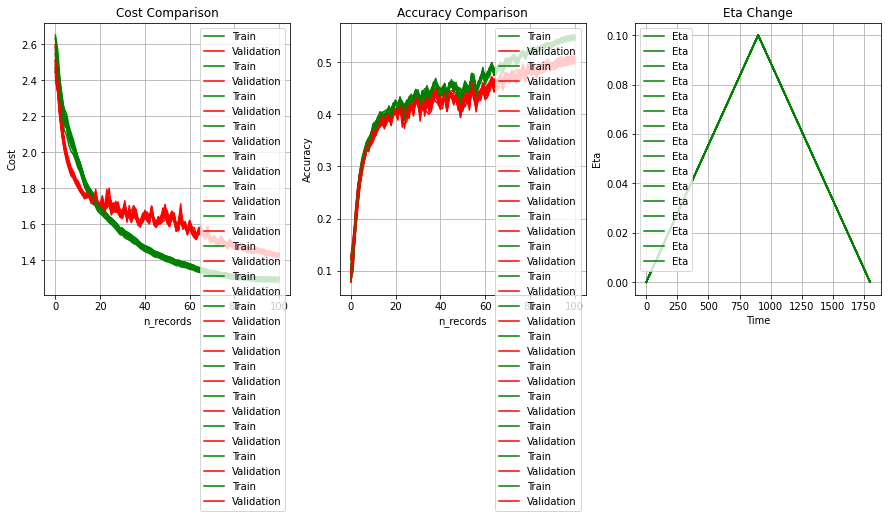

In [17]:
# Search of LAMBDA for a narrower range
# takes around 12 minutes
# HERE we NARROWED the range >> (-5, -1) to (-5, -4) and used 16 samples instead of 8
lambda_coarse_list = []
start_time = datetime.datetime.now()
for i in range(16):
    lambda_coarse = Coarse_Search(-5, -4)
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m,
    #               eta_min, eta_max]
    param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, lambda_coarse, 100, 50, 1e-5, 1e-1]
    layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)
    
    P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
    k_test = np.argmax(P_test, axis=0)
    A_test = network1.ComputeAccuracy(k_test, network1.test_y)
    #lambda_coarse_list.append([lambda_coarse, A_test, W, b])
    lambda_coarse_list.append([lambda_coarse, A_test])
    print(datetime.datetime.now())
    print('Test accuracy of {}. lambda ({})={}'.format(i, lambda_coarse, A_test))
    
Save_Lambda_TestAccuracy(lambda_coarse_list)
end_time = datetime.datetime.now()
print("Calculation time of lambda_coarse: " + str(end_time - start_time))

In [18]:
lambda_coarse_list

[[9.862809522185001e-05, 0.498],
 [9.054812798313612e-05, 0.5001],
 [1.9651064567590842e-05, 0.4968],
 [3.544673306817798e-05, 0.5056],
 [2.653016524046826e-05, 0.4986],
 [2.055764159216546e-05, 0.4959],
 [3.614606936334905e-05, 0.5019],
 [2.6196012000341928e-05, 0.5001],
 [2.406038940258964e-05, 0.4992],
 [5.9831933161984584e-05, 0.495],
 [3.516860763871908e-05, 0.4995],
 [4.459893452752506e-05, 0.4944],
 [1.1067150412880694e-05, 0.5033],
 [1.4001893917970237e-05, 0.4947],
 [1.2967366157634313e-05, 0.4972],
 [2.7575325697602636e-05, 0.5029]]

batch_size: 100, lambda_cost : 0.0002612298487195736, d: 3072, m: 50, K: 10

total_batch: 450, n_steps : 900, n_epochs: 4, n_records: 1800

record_per_cycle: 100, cost_record : 101, comparison_number: 18

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:43:31.141151
J_train: 2.442568468078137 ... smooth_cost : 2.442568468078137 ... J_validation: 2.524581106942363

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:43:31.522641
J_train: 2.325736001677673 ... smooth_cost : 2.384152234877905 ... J_validation: 2.381753093984932

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:43:31.915241
J_train: 2.1305131316502197 ... smooth_cost : 2.299605867135343 ... J_validation: 2.2197249469282934

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:4

cycle_no: 0 ... eta: 0.0698919 ... time: 2020-08-30 19:43:45.529570
J_train: 1.2032424431316384 ... smooth_cost : 1.5163734744284545 ... J_validation: 1.6653880248685593

epoch: 1, batch: 197, n_records: 647, cycle_step: 647
cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:43:45.926991
J_train: 1.3108734021583675 ... smooth_cost : 1.5108194184211547 ... J_validation: 1.639747167810248

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:43:46.323755
J_train: 1.1145069018994767 ... smooth_cost : 1.5003901416705843 ... J_validation: 1.619101523906546

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:43:46.723974
J_train: 1.036890601540861 ... smooth_cost : 1.4885055380775145 ... J_validation: 1.6253844171795668

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:43:47.167609
J_train: 1.16650866889774

cycle_no: 0 ... eta: 0.0581153 ... time: 2020-08-30 19:44:00.925893
J_train: 1.250640212136691 ... smooth_cost : 1.3429673607427748 ... J_validation: 1.5337303005800895

epoch: 2, batch: 395, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:44:01.343096
J_train: 1.0991535493131073 ... smooth_cost : 1.3396274455177106 ... J_validation: 1.5120849405119774

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:44:01.749230
J_train: 1.186284092497797 ... smooth_cost : 1.3375552380444686 ... J_validation: 1.5194699976618555

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:44:02.169457
J_train: 1.0836171896329685 ... smooth_cost : 1.334169397398982 ... J_validation: 1.5363199252675421

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:44:02.595398
J_trai

cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:44:15.199256
J_train: 2.0249984513968133 ... smooth_cost : 2.27406741471957 ... J_validation: 2.143039876184607

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:44:15.609637
J_train: 1.906274558967166 ... smooth_cost : 2.200508843569089 ... J_validation: 2.0501873479450956

epoch: 0, batch: 89, n_records: 89, cycle_step: 89
cycle_no: 0 ... eta: 0.009897900000000001 ... time: 2020-08-30 19:44:16.009491
J_train: 2.063683599300577 ... smooth_cost : 2.1777046361910037 ... J_validation: 1.9893396686622362

epoch: 0, batch: 107, n_records: 107, cycle_step: 107
cycle_no: 0 ... eta: 0.0118977 ... time: 2020-08-30 19:44:16.411348
J_train: 1.7725979459890318 ... smooth_cost : 2.1198322518764363 ... J_validation: 1.9400608217988715

epoch: 0, batch: 125, n_records: 125, cycle_step: 125
cycle_no: 0 ... eta: 0.013897500000000002 ... time: 2020-08-30 19:44:16.809027
J_train: 1

cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:44:30.857043
J_train: 1.1886322668660503 ... smooth_cost : 1.4880752873993717 ... J_validation: 1.6424313314888042

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:44:31.329110
J_train: 1.0671955734459797 ... smooth_cost : 1.4778099285224597 ... J_validation: 1.651720723131926

epoch: 1, batch: 287, n_records: 737, cycle_step: 737
cycle_no: 0 ... eta: 0.08189070000000001 ... time: 2020-08-30 19:44:31.782225
J_train: 1.254892876212339 ... smooth_cost : 1.472502379657933 ... J_validation: 1.6571729861382372

epoch: 1, batch: 305, n_records: 755, cycle_step: 755
cycle_no: 0 ... eta: 0.0838905 ... time: 2020-08-30 19:44:32.193482
J_train: 1.2005796910575457 ... smooth_cost : 1.46617859620211 ... J_validation: 1.616117605847797

epoch: 1, batch: 323, n_records: 773, cycle_step: 773
cycle_no: 0 ... eta: 0.0858903 ... time: 2020-08-30 19:44:32.597159
J_train: 1.149439689890351 .

cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:44:46.384070
J_train: 1.2230356177529194 ... smooth_cost : 1.3255424851302537 ... J_validation: 1.4836954957699888

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:44:46.801216
J_train: 1.202124625448129 ... smooth_cost : 1.3239396557837328 ... J_validation: 1.4872611519073913

epoch: 3, batch: 35, n_records: 1385, cycle_step: 1385
cycle_no: 0 ... eta: 0.046116500000000005 ... time: 2020-08-30 19:44:47.216700
J_train: 1.1511489936240111 ... smooth_cost : 1.321724390884249 ... J_validation: 1.4860992379188567

epoch: 3, batch: 53, n_records: 1403, cycle_step: 1403
cycle_no: 0 ... eta: 0.0441167 ... time: 2020-08-30 19:44:47.624737
J_train: 1.0470427879996131 ... smooth_cost : 1.3182474085692537 ... J_validation: 1.5028098123100933

epoch: 3, batch: 71, n_records: 1421, cycle_step: 1421
cycle_no: 0 ... eta: 0.0421169 ... time: 2020-08-30 19:44:48.03626

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:44:57.392937
J_train: 2.464477670392273 ... smooth_cost : 2.464477670392273 ... J_validation: 2.495914415157551

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:44:57.802230
J_train: 2.28854935072224 ... smooth_cost : 2.376513510557256 ... J_validation: 2.383466613163521

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:44:58.224779
J_train: 2.0719069634957594 ... smooth_cost : 2.2749779948700906 ... J_validation: 2.230759320822104

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:44:58.699096
J_train: 2.023669016385595 ... smooth_cost : 2.212150750248967 ... J_validation: 2.132117718177903

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:44:59.166250
J_train: 1.940893095876

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:45:12.764240
J_train: 1.2701067718813948 ... smooth_cost : 1.5282748883103667 ... J_validation: 1.6652022336431083

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:45:13.175201
J_train: 1.0884547261266178 ... smooth_cost : 1.5167006735160575 ... J_validation: 1.6401405834044782

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:45:13.581489
J_train: 0.9892223013091499 ... smooth_cost : 1.5031755870492138 ... J_validation: 1.6349868217387507

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:45:13.986929
J_train: 1.1634827827460696 ... smooth_cost : 1.4946832669416352 ... J_validation: 1.649635695279369

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:45:14.381541
J_train: 1.132848929103

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:45:27.156387
J_train: 1.157229062099315 ... smooth_cost : 1.3496245833121534 ... J_validation: 1.5275300876662536

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:45:27.551184
J_train: 1.1350048653043725 ... smooth_cost : 1.3467243168525889 ... J_validation: 1.5237474877830004

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:45:27.950511
J_train: 1.0858986584061996 ... smooth_cost : 1.3432466414066369 ... J_validation: 1.530915854958185

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:45:28.359238
J_train: 1.2640545957993403 ... smooth_cost : 1.342204640806541 ... J_validation: 1.5277801987214472

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:45:28.7634

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:45:38.805851
J_train: 2.3776443244447383 ... smooth_cost : 2.3776443244447383 ... J_validation: 2.4469497682417916

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:45:39.210974
J_train: 2.3811642585193957 ... smooth_cost : 2.379404291482067 ... J_validation: 2.334766539016514

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:45:39.619133
J_train: 2.1562440174782807 ... smooth_cost : 2.305017533480805 ... J_validation: 2.188262838039612

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:45:40.030158
J_train: 1.9956220018050033 ... smooth_cost : 2.2276686505618546 ... J_validation: 2.0875669009284286

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:45:40.439006
J_train: 1.95220

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:45:53.221578
J_train: 1.314968555994419 ... smooth_cost : 1.5159767202126713 ... J_validation: 1.6581967481424134

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:45:53.622262
J_train: 1.0842709931118772 ... smooth_cost : 1.504616043183703 ... J_validation: 1.602542412722232

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:45:54.012419
J_train: 0.9947038461557838 ... smooth_cost : 1.4915413714650385 ... J_validation: 1.6109745340886192

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:45:54.409341
J_train: 1.1806815612600954 ... smooth_cost : 1.483769876209915 ... J_validation: 1.6231772227001182

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:45:54.801347
J_train: 1.119505308011008

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:46:08.015805
J_train: 1.117342906802471 ... smooth_cost : 1.3322988118058001 ... J_validation: 1.495132579359597

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:46:08.429494
J_train: 1.1802705575527417 ... smooth_cost : 1.3302443759375155 ... J_validation: 1.4976195844703115

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:46:08.865934
J_train: 1.030305822691737 ... smooth_cost : 1.3262451952275718 ... J_validation: 1.507743092051284

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:46:09.291509
J_train: 1.2243906637301296 ... smooth_cost : 1.324905004023658 ... J_validation: 1.5016968303226397

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:46:09.691881

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:46:20.690561
J_train: 2.5833273638868257 ... smooth_cost : 2.5833273638868257 ... J_validation: 2.4386331372749774

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:46:21.118951
J_train: 2.311023831345029 ... smooth_cost : 2.447175597615927 ... J_validation: 2.347221121195312

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:46:21.523818
J_train: 2.14152579640796 ... smooth_cost : 2.3452923305466045 ... J_validation: 2.227219608955366

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:46:21.941994
J_train: 2.01354745212633 ... smooth_cost : 2.262356110941536 ... J_validation: 2.129907646670585

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:46:22.367118
J_train: 1.87587144448

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:46:35.975734
J_train: 1.231509290114193 ... smooth_cost : 1.514299132392143 ... J_validation: 1.6758033942676638

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:46:36.395849
J_train: 1.1043403861644614 ... smooth_cost : 1.5035107443335198 ... J_validation: 1.6144464671178

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:46:36.807272
J_train: 1.0167647099139066 ... smooth_cost : 1.491030076784299 ... J_validation: 1.6264116858023798

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:46:37.230358
J_train: 1.1981679971156072 ... smooth_cost : 1.4837085247925816 ... J_validation: 1.6442576678111755

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:46:37.669055
J_train: 1.1301294079347155 

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:46:51.186873
J_train: 1.1626804647326454 ... smooth_cost : 1.3422435386166862 ... J_validation: 1.5208569156897718

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:46:51.585735
J_train: 1.1973664114181253 ... smooth_cost : 1.3402857396004895 ... J_validation: 1.5177956545457938

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:46:51.984954
J_train: 1.0590844434527078 ... smooth_cost : 1.3365363889851856 ... J_validation: 1.5201721170995839

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:46:52.386446
J_train: 1.2654285145111814 ... smooth_cost : 1.3356007590578962 ... J_validation: 1.519231177649793

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:46:52.78

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:47:03.092931
J_train: 2.3836054525091392 ... smooth_cost : 2.3836054525091392 ... J_validation: 2.5746930437786877

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:47:03.492716
J_train: 2.349679675738703 ... smooth_cost : 2.366642564123921 ... J_validation: 2.4262966075669894

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:47:03.894030
J_train: 2.2150220004197334 ... smooth_cost : 2.3161023762225255 ... J_validation: 2.2333112982181915

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:47:04.295497
J_train: 1.9824577464166102 ... smooth_cost : 2.2326912187710466 ... J_validation: 2.1247853698472046

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:47:04.699859
J_train: 1.885

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:47:17.970099
J_train: 1.3087147696562536 ... smooth_cost : 1.5009064686352083 ... J_validation: 1.6559830789115604

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:47:18.377552
J_train: 1.116431120324159 ... smooth_cost : 1.4907886963112331 ... J_validation: 1.6234274020039723

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:47:18.780355
J_train: 1.0247015894417637 ... smooth_cost : 1.4788377448530416 ... J_validation: 1.6074007006890159

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:47:19.188478
J_train: 1.201032437971712 ... smooth_cost : 1.4718926121810083 ... J_validation: 1.638455774568807

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:47:19.593377
J_train: 1.11555925990519

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:47:32.748707
J_train: 1.1030711252850327 ... smooth_cost : 1.326034342741434 ... J_validation: 1.4975222379113735

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:47:33.147532
J_train: 1.1470174965967135 ... smooth_cost : 1.323615196171911 ... J_validation: 1.5086046563500226

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:47:33.544927
J_train: 1.0407816631590971 ... smooth_cost : 1.3198440823984066 ... J_validation: 1.519825172084881

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:47:33.951998
J_train: 1.2584846926862792 ... smooth_cost : 1.3190367220074577 ... J_validation: 1.4924147234680516

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:47:34.3517

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:47:44.469418
J_train: 2.644765456891377 ... smooth_cost : 2.644765456891377 ... J_validation: 2.6120305625029294

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:47:44.868533
J_train: 2.4578398661989866 ... smooth_cost : 2.551302661545182 ... J_validation: 2.473426343711864

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:47:45.265538
J_train: 2.278836105156325 ... smooth_cost : 2.4604804760822296 ... J_validation: 2.296730820401083

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:47:45.664729
J_train: 2.1245264863215203 ... smooth_cost : 2.3764919786420524 ... J_validation: 2.1792220402355507

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:47:46.063977
J_train: 1.9822033

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:47:59.821389
J_train: 1.3247928117287275 ... smooth_cost : 1.5594971231625994 ... J_validation: 1.6517342061993092

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:48:00.226699
J_train: 1.141707934849087 ... smooth_cost : 1.5485026708385596 ... J_validation: 1.6147043246043333

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:48:00.638349
J_train: 1.033074572606791 ... smooth_cost : 1.5352865657556938 ... J_validation: 1.6038506919854205

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:48:01.042380
J_train: 1.1939644516939547 ... smooth_cost : 1.5267535129041503 ... J_validation: 1.6360779485643488

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:48:01.452925
J_train: 1.1425643641381

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:48:14.649453
J_train: 1.1144926144303704 ... smooth_cost : 1.370602591354317 ... J_validation: 1.5270714245198005

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:48:15.051378
J_train: 1.2380119436021266 ... smooth_cost : 1.3688108258441525 ... J_validation: 1.5208592925320008

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:48:15.452407
J_train: 1.088829662997577 ... smooth_cost : 1.3650777436728647 ... J_validation: 1.5438490669377491

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:48:15.857408
J_train: 1.2563578350551876 ... smooth_cost : 1.3636472185594741 ... J_validation: 1.525672989584955

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:48:16.2672

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:48:26.384991
J_train: 2.391596053398852 ... smooth_cost : 2.391596053398852 ... J_validation: 2.5239915086382263

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:48:26.790109
J_train: 2.3642869186472093 ... smooth_cost : 2.3779414860230306 ... J_validation: 2.4058658828619195

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:48:27.189755
J_train: 2.1644864089597955 ... smooth_cost : 2.306789793668619 ... J_validation: 2.250795872463335

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:48:27.591701
J_train: 1.9849088737134528 ... smooth_cost : 2.2263195636798274 ... J_validation: 2.151130446027695

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:48:27.989333
J_train: 1.850472

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:48:40.973315
J_train: 1.241128941877052 ... smooth_cost : 1.4982974463547885 ... J_validation: 1.6440091552396228

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:48:41.376115
J_train: 1.060433449928766 ... smooth_cost : 1.4867747096067354 ... J_validation: 1.610719238438844

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:48:41.782164
J_train: 1.0088044518874835 ... smooth_cost : 1.4745190619729083 ... J_validation: 1.6022747172126277

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:48:42.206492
J_train: 1.1576564168616028 ... smooth_cost : 1.4665974958451258 ... J_validation: 1.650526006624133

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:48:42.627283
J_train: 1.16294619585795 

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:48:56.640199
J_train: 1.1091991319198984 ... smooth_cost : 1.3235478459137073 ... J_validation: 1.4930022721562322

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:48:57.040327
J_train: 1.1614954513736284 ... smooth_cost : 1.3213579486901927 ... J_validation: 1.4894706426163682

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:48:57.446733
J_train: 1.0727866224846982 ... smooth_cost : 1.318043664340786 ... J_validation: 1.5100258537600577

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:48:57.858090
J_train: 1.2199324823583195 ... smooth_cost : 1.3167527277357536 ... J_validation: 1.4789567211669234

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:48:58.26

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:49:08.615301
J_train: 2.520911481255458 ... smooth_cost : 2.520911481255458 ... J_validation: 2.4691102978239736

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:49:09.025672
J_train: 2.4471396435737813 ... smooth_cost : 2.4840255624146197 ... J_validation: 2.382635761623075

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:49:09.439921
J_train: 2.0522362665748526 ... smooth_cost : 2.340095797134697 ... J_validation: 2.241240169916641

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:49:09.850635
J_train: 1.9994733674990117 ... smooth_cost : 2.254940189725776 ... J_validation: 2.1256431739379598

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:49:10.281617
J_train: 1.9345235

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:49:24.190671
J_train: 1.2564395111703577 ... smooth_cost : 1.494777816773423 ... J_validation: 1.6461825247786737

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:49:24.597278
J_train: 1.0876310328368148 ... smooth_cost : 1.4840634277224596 ... J_validation: 1.6431858210680783

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:49:25.018601
J_train: 0.981901213555838 ... smooth_cost : 1.471187473513059 ... J_validation: 1.6150305197434864

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:49:25.425484
J_train: 1.1484949476237047 ... smooth_cost : 1.463120160365825 ... J_validation: 1.6352248488028716

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:49:25.830995
J_train: 1.132212113259996

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:49:39.394911
J_train: 1.1387093241938535 ... smooth_cost : 1.3270143817124032 ... J_validation: 1.521045924194927

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:49:39.839097
J_train: 1.1875886263400803 ... smooth_cost : 1.3251302498830477 ... J_validation: 1.5022626019064564

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:49:40.266995
J_train: 1.093457918029268 ... smooth_cost : 1.3220412854583306 ... J_validation: 1.527183190481183

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:49:40.687379
J_train: 1.2225094740973865 ... smooth_cost : 1.3207316563614762 ... J_validation: 1.5084832695110444

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:49:41.1114

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:49:51.596988
J_train: 2.438034461907932 ... smooth_cost : 2.438034461907932 ... J_validation: 2.4814520319386077

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:49:52.025328
J_train: 2.4156547244920255 ... smooth_cost : 2.426844593199979 ... J_validation: 2.373833846858983

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:49:52.444434
J_train: 2.1717738337452692 ... smooth_cost : 2.3418210067150755 ... J_validation: 2.2264200447334748

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:49:52.857126
J_train: 2.0223407436546097 ... smooth_cost : 2.2619509409499594 ... J_validation: 2.1121608335804907

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:49:53.259190
J_train: 1.90394

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:50:07.436012
J_train: 1.2819361485119232 ... smooth_cost : 1.5207771904709957 ... J_validation: 1.6425559905439246

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:50:07.858894
J_train: 1.0867803984042474 ... smooth_cost : 1.509356222258713 ... J_validation: 1.607421021036462

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:50:08.336808
J_train: 1.0148195521281214 ... smooth_cost : 1.496675794819467 ... J_validation: 1.5906523603479135

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:50:08.868880
J_train: 1.1650326019129427 ... smooth_cost : 1.488384714996804 ... J_validation: 1.6270127145854498

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:50:09.346391
J_train: 1.192887520705932

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:50:23.554257
J_train: 1.1914435297663482 ... smooth_cost : 1.3413450885356983 ... J_validation: 1.5020383208285464

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:50:23.952700
J_train: 1.1999320250120837 ... smooth_cost : 1.3394341011907849 ... J_validation: 1.4903392599314913

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:50:24.356763
J_train: 1.007209305478982 ... smooth_cost : 1.3350044372479608 ... J_validation: 1.4959575526630502

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:50:24.758426
J_train: 1.2502380883626931 ... smooth_cost : 1.333889090552102 ... J_validation: 1.4970666083145157

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:50:25.156

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:50:35.618004
J_train: 2.478105106093113 ... smooth_cost : 2.478105106093113 ... J_validation: 2.509733010556653

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:50:36.024876
J_train: 2.3951077099889773 ... smooth_cost : 2.4366064080410452 ... J_validation: 2.3982311329837005

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:50:36.448613
J_train: 2.1300919105004894 ... smooth_cost : 2.33443490886086 ... J_validation: 2.247309178229631

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:50:36.878333
J_train: 2.071411171187049 ... smooth_cost : 2.268678974442407 ... J_validation: 2.1453170078142336

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:50:37.300803
J_train: 1.941651837

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:50:50.386347
J_train: 1.2766858914432726 ... smooth_cost : 1.5403641035453017 ... J_validation: 1.6674664593487583

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:50:50.782813
J_train: 1.1495302869741022 ... smooth_cost : 1.5300790031092177 ... J_validation: 1.6443405459665217

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:50:51.187981
J_train: 1.047163362876953 ... smooth_cost : 1.5176965507955698 ... J_validation: 1.6393268311967804

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:50:51.610809
J_train: 1.2011232233614844 ... smooth_cost : 1.5097822176097178 ... J_validation: 1.6604500918572167

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:50:52.036955
J_train: 1.164356514639

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:51:05.227414
J_train: 1.2243704786469598 ... smooth_cost : 1.3661989231292333 ... J_validation: 1.541355119590135

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:51:05.674167
J_train: 1.2572357628707587 ... smooth_cost : 1.3647264479906052 ... J_validation: 1.5428469739235828

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:51:06.100529
J_train: 1.1519634902559495 ... smooth_cost : 1.3618896085541432 ... J_validation: 1.5603780529883948

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:51:06.517062
J_train: 1.2859579270210122 ... smooth_cost : 1.3608905074813389 ... J_validation: 1.5652079575413576

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:51:06.92

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:51:17.299351
J_train: 2.554212226086553 ... smooth_cost : 2.554212226086553 ... J_validation: 2.540027708175723

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:51:17.705279
J_train: 2.3640872321502346 ... smooth_cost : 2.459149729118394 ... J_validation: 2.422784677340178

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:51:18.102477
J_train: 2.1429573494146315 ... smooth_cost : 2.3537522692171398 ... J_validation: 2.2541926249287103

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:51:18.515646
J_train: 2.0214121938055465 ... smooth_cost : 2.2706672503642418 ... J_validation: 2.140872963517605

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:51:18.932506
J_train: 1.8846621

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:51:32.021561
J_train: 1.3267907554416407 ... smooth_cost : 1.5181562217348874 ... J_validation: 1.6629145703308736

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:51:32.430302
J_train: 1.0826346236460374 ... smooth_cost : 1.5066951270483386 ... J_validation: 1.6231042630260895

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:51:32.846647
J_train: 1.0142125221177223 ... smooth_cost : 1.4940673679475536 ... J_validation: 1.6107577051053112

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:51:33.267689
J_train: 1.1675221539288247 ... smooth_cost : 1.4859037375970854 ... J_validation: 1.6415610865554593

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:51:33.687221
J_train: 1.15743607295

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:51:47.186076
J_train: 1.1025118943154404 ... smooth_cost : 1.334862378835665 ... J_validation: 1.5020028712704503

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:51:47.587643
J_train: 1.2031517616098215 ... smooth_cost : 1.3330825056299103 ... J_validation: 1.5085229749688664

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:51:47.995555
J_train: 1.0314764322382066 ... smooth_cost : 1.329061091318021 ... J_validation: 1.5306902107902285

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:51:48.407190
J_train: 1.2373192398717343 ... smooth_cost : 1.3278539616937277 ... J_validation: 1.5064675409514603

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:51:48.820

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:51:59.744298
J_train: 2.6350651771623137 ... smooth_cost : 2.6350651771623137 ... J_validation: 2.527305228533297

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:52:00.152963
J_train: 2.481477460485458 ... smooth_cost : 2.558271318823886 ... J_validation: 2.410792970878678

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:52:00.559931
J_train: 2.1766610425828823 ... smooth_cost : 2.431067893410218 ... J_validation: 2.2785690882581466

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:52:00.965919
J_train: 2.120635408976754 ... smooth_cost : 2.3534597723018518 ... J_validation: 2.183713427321122

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:52:01.367727
J_train: 1.92924727

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:52:14.890985
J_train: 1.323712680989706 ... smooth_cost : 1.5482449813520796 ... J_validation: 1.6660092593376963

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:52:15.443755
J_train: 1.1565427698307333 ... smooth_cost : 1.5379370284173073 ... J_validation: 1.630146534129868

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:52:15.881972
J_train: 1.0343612080199267 ... smooth_cost : 1.5250248278942975 ... J_validation: 1.6227693036104798

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:52:16.372577
J_train: 1.1850169329347626 ... smooth_cost : 1.516524630520309 ... J_validation: 1.649941057542039

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:52:16.808488
J_train: 1.172609152310539

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:52:31.605315
J_train: 1.157176053355641 ... smooth_cost : 1.3733399267795765 ... J_validation: 1.529971188808518

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:52:32.045295
J_train: 1.194246727548627 ... smooth_cost : 1.3709197484115907 ... J_validation: 1.5185604638540533

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:52:32.464164
J_train: 1.047025913317141 ... smooth_cost : 1.3666011639436646 ... J_validation: 1.5520817874093122

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:52:32.927619
J_train: 1.2472520967413616 ... smooth_cost : 1.3650307814804765 ... J_validation: 1.5322825948038374

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:52:33.38276

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:52:44.050823
J_train: 2.446443261610823 ... smooth_cost : 2.446443261610823 ... J_validation: 2.5076468137129218

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:52:44.461442
J_train: 2.339179679470431 ... smooth_cost : 2.392811470540627 ... J_validation: 2.3793380247933413

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:52:44.918765
J_train: 2.0948997210531344 ... smooth_cost : 2.2935075540447962 ... J_validation: 2.2268378696340885

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:52:45.361917
J_train: 2.089786275261031 ... smooth_cost : 2.242577234348855 ... J_validation: 2.1334134151994664

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:52:45.813470
J_train: 1.9505588

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:52:59.607000
J_train: 1.2804700977265795 ... smooth_cost : 1.508541295643353 ... J_validation: 1.6357459128698952

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:53:00.079734
J_train: 1.1086079900095311 ... smooth_cost : 1.4980167349687787 ... J_validation: 1.6143644512270832

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:53:00.535235
J_train: 0.9865557431865198 ... smooth_cost : 1.4849023505641055 ... J_validation: 1.6210985356391707

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:53:00.994299
J_train: 1.1423919850768387 ... smooth_cost : 1.476339591426924 ... J_validation: 1.627893902689145

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:53:01.461347
J_train: 1.10274814168067

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:53:15.765876
J_train: 1.108449680630623 ... smooth_cost : 1.3274728101562951 ... J_validation: 1.5067138966938973

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:53:16.171430
J_train: 1.1869520097406028 ... smooth_cost : 1.325573880420948 ... J_validation: 1.4958875772150515

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:53:16.581722
J_train: 1.0782070580146716 ... smooth_cost : 1.3222756561221978 ... J_validation: 1.5085914338802224

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:53:17.006730
J_train: 1.2498896248983988 ... smooth_cost : 1.3213232083429371 ... J_validation: 1.5159973374256603

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:53:17.428

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:53:28.149809
J_train: 2.6481730191040955 ... smooth_cost : 2.6481730191040955 ... J_validation: 2.584699361120168

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:53:28.568314
J_train: 2.44685531726226 ... smooth_cost : 2.5475141681831777 ... J_validation: 2.4408069770667145

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-30 19:53:28.986499
J_train: 2.174359093192615 ... smooth_cost : 2.423129143186323 ... J_validation: 2.3046477019878098

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-30 19:53:29.437839
J_train: 2.0726131904938563 ... smooth_cost : 2.3355001550132064 ... J_validation: 2.193300423680691

epoch: 0, batch: 71, n_records: 71, cycle_step: 71
cycle_no: 0 ... eta: 0.0078981 ... time: 2020-08-30 19:53:29.893330
J_train: 1.9527451

cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:53:43.543271
J_train: 1.3159059027280775 ... smooth_cost : 1.5650586541356564 ... J_validation: 1.680186785420981

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:53:43.992582
J_train: 1.1285199294796844 ... smooth_cost : 1.5535707929604992 ... J_validation: 1.6461236303818187

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:53:44.411156
J_train: 1.0768155871639389 ... smooth_cost : 1.5413463005041772 ... J_validation: 1.6416864759865473

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-30 19:53:44.838829
J_train: 1.2078748329919118 ... smooth_cost : 1.5330095138163706 ... J_validation: 1.6682426192016286

epoch: 1, batch: 269, n_records: 719, cycle_step: 719
cycle_no: 0 ... eta: 0.0798909 ... time: 2020-08-30 19:53:45.239691
J_train: 1.236070740617

cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:53:58.491831
J_train: 1.2157047128798728 ... smooth_cost : 1.389075187387121 ... J_validation: 1.544642037406104

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:53:58.903511
J_train: 1.2302527981845295 ... smooth_cost : 1.3869289388843833 ... J_validation: 1.5395099944528443

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:53:59.315978
J_train: 1.1392355959737475 ... smooth_cost : 1.383626360978908 ... J_validation: 1.5564044032943944

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-30 19:53:59.746936
J_train: 1.2900471896153651 ... smooth_cost : 1.3823950560925455 ... J_validation: 1.539387815012996

epoch: 3, batch: 17, n_records: 1367, cycle_step: 1367
cycle_no: 0 ... eta: 0.04811630000000001 ... time: 2020-08-30 19:54:00.14933

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

batch_size: 100, lambda_cost : 0.0007396340420651542, d: 3072, m: 50, K: 10

total_batch: 450, n_steps : 900, n_epochs: 4, n_records: 1800

record_per_cycle: 100, cost_record : 101, comparison_number: 18
2020-08-30 19:54:10.358263
Test accuracy of 14. lambda (0.0007396340420651542)=0.4968
batch_size: 100, lambda_cost : 0.0001016683203334642, d: 3072, m: 50, K: 10

total_batch: 450, n_steps : 900, n_epochs: 4, n_records: 1800

record_per_cycle: 100, cost_record : 101, comparison_number: 18

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-30 19:54:10.768032
J_train: 2.741118235474216 ... smooth_cost : 2.741118235474216 ... J_validation: 2.610087794286526

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-30 19:54:11.183055
J_train: 2.4453812587543506 ... smooth_cost : 2.5932497471142835 ... J_validation: 2.4473742064210984

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no

cycle_no: 0 ... eta: 0.0678921 ... time: 2020-08-30 19:54:25.096345
J_train: 1.19043614687963 ... smooth_cost : 1.5340254726676033 ... J_validation: 1.6417335314372599

epoch: 1, batch: 179, n_records: 629, cycle_step: 629
cycle_no: 0 ... eta: 0.0698919 ... time: 2020-08-30 19:54:25.499967
J_train: 1.1448536490453085 ... smooth_cost : 1.5232151442336506 ... J_validation: 1.6730095572650843

epoch: 1, batch: 197, n_records: 647, cycle_step: 647
cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-30 19:54:25.908708
J_train: 1.2762024485401826 ... smooth_cost : 1.5165391254311245 ... J_validation: 1.6453910640731964

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-30 19:54:26.314449
J_train: 1.1047924546716938 ... smooth_cost : 1.505703686726929 ... J_validation: 1.6182574582041962

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-30 19:54:26.719329
J_train: 1.02352008796024

cycle_no: 0 ... eta: 0.0601151 ... time: 2020-08-30 19:54:39.695867
J_train: 1.2404595973237316 ... smooth_cost : 1.3426164132535907 ... J_validation: 1.5235650128351688

epoch: 2, batch: 377, n_records: 1277, cycle_step: 1277
cycle_no: 0 ... eta: 0.0581153 ... time: 2020-08-30 19:54:40.096840
J_train: 1.3244128174813206 ... smooth_cost : 1.3423635855345313 ... J_validation: 1.518109711400104

epoch: 2, batch: 395, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-30 19:54:40.510675
J_train: 1.131518735646496 ... smooth_cost : 1.3394752999196267 ... J_validation: 1.5008104450093211

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-30 19:54:40.919909
J_train: 1.1879324277066707 ... smooth_cost : 1.3374274232681003 ... J_validation: 1.506662039611262

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-30 19:54:41.334518
J_train: 1.035397

/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/Users/melih/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

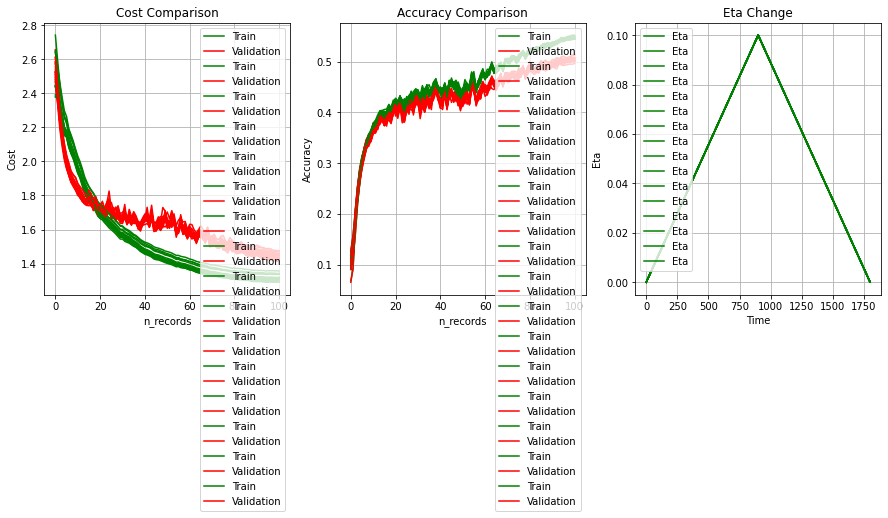

In [14]:
# Search of LAMBDA for a narrower range
# takes around 12 minutes
# HERE we NARROWED the range >> (-5, -1) to (-5, -4) and used 16 samples instead of 8
lambda_coarse_list = []
start_time = datetime.datetime.now()
for i in range(16):
    lambda_coarse = Coarse_Search(-5, -3)
    # param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m,
    #               eta_min, eta_max]
    param_list = [network1, train_X_Norm, validation_X_Norm, 100, 1, lambda_coarse, 100, 50, 1e-5, 1e-1]
    layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)
    
    P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
    k_test = np.argmax(P_test, axis=0)
    A_test = network1.ComputeAccuracy(k_test, network1.test_y)
    #lambda_coarse_list.append([lambda_coarse, A_test, W, b])
    lambda_coarse_list.append([lambda_coarse, A_test])
    print(datetime.datetime.now())
    print('Test accuracy of {}. lambda ({})={}'.format(i, lambda_coarse, A_test))
    
Save_Lambda_TestAccuracy(lambda_coarse_list)
end_time = datetime.datetime.now()
print("Calculation time of lambda_coarse: " + str(end_time - start_time))

In [15]:
lambda_coarse_list

[[0.0002612298487195736, 0.4954],
 [6.503713689980735e-05, 0.4973],
 [0.0004215372047767062, 0.4988],
 [1.8161231262606217e-05, 0.4991],
 [0.0003026456374925449, 0.4989],
 [5.260979986414023e-05, 0.4971],
 [0.00046666178523047065, 0.4978],
 [1.500921867517104e-05, 0.5009],
 [0.00010091058853135455, 0.495],
 [3.603435649035082e-05, 0.494],
 [0.0005889884070375094, 0.4969],
 [6.588652468387348e-05, 0.4986],
 [0.0005657028755680419, 0.4965],
 [5.430998650173837e-05, 0.4995],
 [0.0007396340420651542, 0.4968],
 [0.0001016683203334642, 0.4938]]

batch_size: 100, lambda_cost : 3.544673306817798e-05, d: 3072, m: 50, K: 10

total_batch: 450, n_steps : 900, n_epochs: 12, n_records: 5400

record_per_cycle: 100, cost_record : 301, comparison_number: 18

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:10:11.327490
J_train: 2.604780354748748 ... smooth_cost : 2.604780354748748 ... J_validation: 2.4387344987918667

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:10:11.726284
J_train: 2.201092607444466 ... smooth_cost : 2.402936481096607 ... J_validation: 2.3679769189233046

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:10:12.133459
J_train: 2.233343333618731 ... smooth_cost : 2.346405431937315 ... J_validation: 2.2310237835531703

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 00

cycle_no: 0 ... eta: 0.0698919 ... time: 2020-08-20 00:10:25.501267
J_train: 1.1634863593809157 ... smooth_cost : 1.509299749217777 ... J_validation: 1.6601539722546532

epoch: 1, batch: 197, n_records: 647, cycle_step: 647
cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:10:25.976249
J_train: 1.282745027022302 ... smooth_cost : 1.5031766486178992 ... J_validation: 1.6237465973295333

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:10:26.431959
J_train: 1.0701817593789806 ... smooth_cost : 1.4917820462695068 ... J_validation: 1.596345623027885

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:10:26.853405
J_train: 1.0203111233623654 ... smooth_cost : 1.4796930482462467 ... J_validation: 1.6030062534624923

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:10:27.286718
J_train: 1.11308350340919

cycle_no: 0 ... eta: 0.0581153 ... time: 2020-08-20 00:10:41.146277
J_train: 1.296224811685364 ... smooth_cost : 1.3320175076886014 ... J_validation: 1.516451080144769

epoch: 2, batch: 395, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:10:41.617860
J_train: 1.0814658399469845 ... smooth_cost : 1.328585293062004 ... J_validation: 1.4995848047045697

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:10:42.053068
J_train: 1.184507893895658 ... smooth_cost : 1.3266383011813776 ... J_validation: 1.4957946972815972

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:10:42.487479
J_train: 1.071389638222136 ... smooth_cost : 1.3232349856752543 ... J_validation: 1.505439326146943

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:10:42.923294
J_train: 

cycle_no: 1 ... eta: 0.013897500000000002 ... time: 2020-08-20 00:10:57.024429
J_train: 1.2760261128669645 ... smooth_cost : 1.2954826398590427 ... J_validation: 1.428614551388797

epoch: 4, batch: 143, n_records: 1943, cycle_step: 143
cycle_no: 1 ... eta: 0.0158973 ... time: 2020-08-20 00:10:57.453440
J_train: 1.3861306426761502 ... smooth_cost : 1.2963142729124104 ... J_validation: 1.4371330331699266

epoch: 4, batch: 161, n_records: 1961, cycle_step: 161
cycle_no: 1 ... eta: 0.0178971 ... time: 2020-08-20 00:10:57.882313
J_train: 1.081827275379316 ... smooth_cost : 1.2943643911166551 ... J_validation: 1.4378155136332218

epoch: 4, batch: 179, n_records: 1979, cycle_step: 179
cycle_no: 1 ... eta: 0.019896900000000002 ... time: 2020-08-20 00:10:58.302074
J_train: 1.1409210998856951 ... smooth_cost : 1.2929820191235835 ... J_validation: 1.4407522171533353

epoch: 4, batch: 197, n_records: 1997, cycle_step: 197
cycle_no: 1 ... eta: 0.0218967 ... time: 2020-08-20 00:10:58.734528
J_train:

cycle_no: 1 ... eta: 0.0858903 ... time: 2020-08-20 00:11:12.495436
J_train: 1.0286971561613751 ... smooth_cost : 1.2388633065156112 ... J_validation: 1.6461023982160814

epoch: 5, batch: 341, n_records: 2591, cycle_step: 791
cycle_no: 1 ... eta: 0.08789010000000001 ... time: 2020-08-20 00:11:12.909836
J_train: 0.81220461476658 ... smooth_cost : 1.2359208327794111 ... J_validation: 1.5328781985925748

epoch: 5, batch: 359, n_records: 2609, cycle_step: 809
cycle_no: 1 ... eta: 0.0898899 ... time: 2020-08-20 00:11:13.324056
J_train: 1.0793320545611094 ... smooth_cost : 1.2348483069012035 ... J_validation: 1.5431587128400215

epoch: 5, batch: 377, n_records: 2627, cycle_step: 827
cycle_no: 1 ... eta: 0.0918897 ... time: 2020-08-20 00:11:13.740786
J_train: 1.1301133532232384 ... smooth_cost : 1.2341358242231222 ... J_validation: 1.5782731300895836

epoch: 5, batch: 395, n_records: 2645, cycle_step: 845
cycle_no: 1 ... eta: 0.0938895 ... time: 2020-08-20 00:11:14.155783
J_train: 1.034800413

cycle_no: 1 ... eta: 0.0421169 ... time: 2020-08-20 00:11:28.634655
J_train: 0.9716568185167066 ... smooth_cost : 1.1937707924742922 ... J_validation: 1.461850223632691

epoch: 7, batch: 89, n_records: 3239, cycle_step: 1439
cycle_no: 1 ... eta: 0.040117099999999996 ... time: 2020-08-20 00:11:29.072034
J_train: 1.3445590136239387 ... smooth_cost : 1.1946038765690417 ... J_validation: 1.4437691573063514

epoch: 7, batch: 107, n_records: 3257, cycle_step: 1457
cycle_no: 1 ... eta: 0.03811729999999999 ... time: 2020-08-20 00:11:29.506706
J_train: 0.8899933828488247 ... smooth_cost : 1.192930192537612 ... J_validation: 1.4506013443404426

epoch: 7, batch: 125, n_records: 3275, cycle_step: 1475
cycle_no: 1 ... eta: 0.03611750000000001 ... time: 2020-08-20 00:11:29.939112
J_train: 1.0926922424530183 ... smooth_cost : 1.1923824441764939 ... J_validation: 1.442391353812426

epoch: 7, batch: 143, n_records: 3293, cycle_step: 1493
cycle_no: 1 ... eta: 0.0341177 ... time: 2020-08-20 00:11:30.3771

cycle_no: 2 ... eta: 0.0298959 ... time: 2020-08-20 00:11:43.919295
J_train: 1.005755039320302 ... smooth_cost : 1.18241858780881 ... J_validation: 1.4570436682492065

epoch: 8, batch: 287, n_records: 3887, cycle_step: 287
cycle_no: 2 ... eta: 0.031895700000000006 ... time: 2020-08-20 00:11:44.332200
J_train: 1.0883297457658636 ... smooth_cost : 1.1819849986749715 ... J_validation: 1.4547077931774344

epoch: 8, batch: 305, n_records: 3905, cycle_step: 305
cycle_no: 2 ... eta: 0.03389550000000001 ... time: 2020-08-20 00:11:44.746737
J_train: 1.0410536944498716 ... smooth_cost : 1.1813385248023793 ... J_validation: 1.451385703162916

epoch: 8, batch: 323, n_records: 3923, cycle_step: 323
cycle_no: 2 ... eta: 0.035895300000000005 ... time: 2020-08-20 00:11:45.185926
J_train: 1.0166092329968914 ... smooth_cost : 1.1805863362553224 ... J_validation: 1.4819752917173628

epoch: 8, batch: 341, n_records: 3941, cycle_step: 341
cycle_no: 2 ... eta: 0.03789510000000001 ... time: 2020-08-20 00:11:

cycle_no: 2 ... eta: 0.09811130000000001 ... time: 2020-08-20 00:12:00.630441
J_train: 0.9667236762815151 ... smooth_cost : 1.1501438044833203 ... J_validation: 1.5707569972860551

epoch: 10, batch: 35, n_records: 4535, cycle_step: 935
cycle_no: 2 ... eta: 0.0961115 ... time: 2020-08-20 00:12:01.068622
J_train: 1.0952056833512671 ... smooth_cost : 1.1499266577594782 ... J_validation: 1.6292631781455231

epoch: 10, batch: 53, n_records: 4553, cycle_step: 953
cycle_no: 2 ... eta: 0.0941117 ... time: 2020-08-20 00:12:01.500483
J_train: 0.7385270756159659 ... smooth_cost : 1.1483069743652126 ... J_validation: 1.6229621865771406

epoch: 10, batch: 71, n_records: 4571, cycle_step: 971
cycle_no: 2 ... eta: 0.09211190000000001 ... time: 2020-08-20 00:12:01.929523
J_train: 0.8681377051550347 ... smooth_cost : 1.147208271348702 ... J_validation: 1.5497918795635357

epoch: 10, batch: 89, n_records: 4589, cycle_step: 989
cycle_no: 2 ... eta: 0.0901121 ... time: 2020-08-20 00:12:02.352655
J_train: 

cycle_no: 2 ... eta: 0.02611849999999999 ... time: 2020-08-20 00:12:15.797393
J_train: 0.9564020734231061 ... smooth_cost : 1.1250628928491446 ... J_validation: 1.4355412627730784

epoch: 11, batch: 233, n_records: 5183, cycle_step: 1583
cycle_no: 2 ... eta: 0.024118700000000007 ... time: 2020-08-20 00:12:16.239668
J_train: 0.8816072092872393 ... smooth_cost : 1.1242204856395879 ... J_validation: 1.435366802007566

epoch: 11, batch: 251, n_records: 5201, cycle_step: 1601
cycle_no: 2 ... eta: 0.022118899999999997 ... time: 2020-08-20 00:12:16.670343
J_train: 1.1114303293268457 ... smooth_cost : 1.1241763816523025 ... J_validation: 1.444147804497622

epoch: 11, batch: 269, n_records: 5219, cycle_step: 1619
cycle_no: 2 ... eta: 0.0201191 ... time: 2020-08-20 00:12:17.096141
J_train: 1.0090658085437518 ... smooth_cost : 1.1237808126725481 ... J_validation: 1.436750479875312

epoch: 11, batch: 287, n_records: 5237, cycle_step: 1637
cycle_no: 2 ... eta: 0.01811929999999999 ... time: 2020-08-

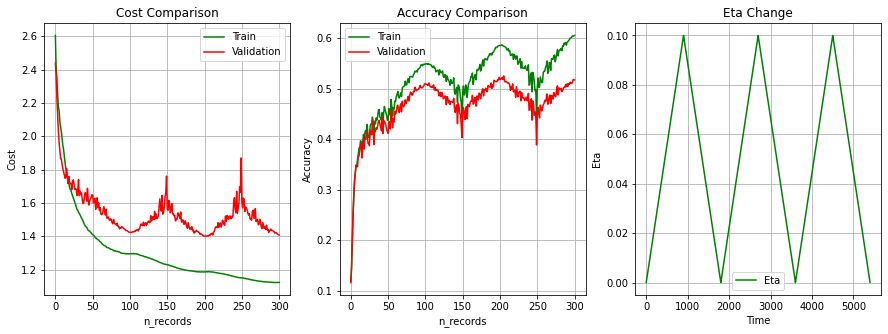

In [19]:
# In this functions, I didn't calculate the cost for each batch but I calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes ONLY 2 minutes 12 seconds!
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, lambda_coarse, 100, 50, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)


In [20]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.5091


batch_size: 200, lambda_cost : 3.544673306817798e-05, d: 3072, m: 50, K: 10

total_batch: 225, n_steps : 450, n_epochs: 12, n_records: 2700

record_per_cycle: 100, cost_record : 301, comparison_number: 9

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:15:14.076611
J_train: 2.457139095993635 ... smooth_cost : 2.457139095993635 ... J_validation: 2.5366486815917355

epoch: 0, batch: 8, n_records: 8, cycle_step: 8
cycle_no: 0 ... eta: 0.0017876000000000003 ... time: 2020-08-20 00:15:14.460735
J_train: 2.4149434757524837 ... smooth_cost : 2.4360412858730593 ... J_validation: 2.4603647322292623

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0037874000000000002 ... time: 2020-08-20 00:15:14.857260
J_train: 2.3539996858662273 ... smooth_cost : 2.4086940858707817 ... J_validation: 2.3419782908029125

epoch: 0, batch: 26, n_records: 26, cycle_step: 26
cycle_no: 0 ... eta: 0.0057872 ... time: 2020-08-20 00:15:15.25553

cycle_no: 0 ... eta: 0.0697808 ... time: 2020-08-20 00:15:27.946273
J_train: 1.3280128405694114 ... smooth_cost : 1.684444824122859 ... J_validation: 1.6576791113846747

epoch: 1, batch: 98, n_records: 323, cycle_step: 323
cycle_no: 0 ... eta: 0.0717806 ... time: 2020-08-20 00:15:28.363876
J_train: 1.3633712297277973 ... smooth_cost : 1.675767159409479 ... J_validation: 1.6442227375822256

epoch: 1, batch: 107, n_records: 332, cycle_step: 332
cycle_no: 0 ... eta: 0.0737804 ... time: 2020-08-20 00:15:28.779279
J_train: 1.2712617070542855 ... smooth_cost : 1.6651222790843423 ... J_validation: 1.6265036596801519

epoch: 1, batch: 116, n_records: 341, cycle_step: 341
cycle_no: 0 ... eta: 0.0757802 ... time: 2020-08-20 00:15:29.185884
J_train: 1.234471122655619 ... smooth_cost : 1.654079941740016 ... J_validation: 1.626646464949992

epoch: 1, batch: 125, n_records: 350, cycle_step: 350
cycle_no: 0 ... eta: 0.07778 ... time: 2020-08-20 00:15:29.590789
J_train: 1.2334352679141978 ... smooth_c

cycle_no: 0 ... eta: 0.0562266 ... time: 2020-08-20 00:15:43.051233
J_train: 1.2412095350449608 ... smooth_cost : 1.4834843252708496 ... J_validation: 1.4942666437808043

epoch: 2, batch: 206, n_records: 656, cycle_step: 656
cycle_no: 0 ... eta: 0.0542268 ... time: 2020-08-20 00:15:43.457036
J_train: 1.332816633944252 ... smooth_cost : 1.4814482753880576 ... J_validation: 1.495153153558981

epoch: 2, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.052226999999999996 ... time: 2020-08-20 00:15:43.868186
J_train: 1.2413415760045545 ... smooth_cost : 1.478246852729611 ... J_validation: 1.5053227680831553

epoch: 2, batch: 224, n_records: 674, cycle_step: 674
cycle_no: 0 ... eta: 0.0502272 ... time: 2020-08-20 00:15:44.291796
J_train: 1.3269769947139838 ... smooth_cost : 1.4762564598609844 ... J_validation: 1.4854766341931613

epoch: 3, batch: 8, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.048227400000000004 ... time: 2020-08-20 00:15:44.703626
J_train: 1.3311

cycle_no: 1 ... eta: 0.0157862 ... time: 2020-08-20 00:15:57.942430
J_train: 1.4142640778295315 ... smooth_cost : 1.4303645859814431 ... J_validation: 1.4433584519491314

epoch: 4, batch: 80, n_records: 980, cycle_step: 80
cycle_no: 1 ... eta: 0.017786000000000003 ... time: 2020-08-20 00:15:58.362939
J_train: 1.2423138734495116 ... smooth_cost : 1.4286550340493347 ... J_validation: 1.4505044948117969

epoch: 4, batch: 89, n_records: 989, cycle_step: 89
cycle_no: 1 ... eta: 0.019785800000000003 ... time: 2020-08-20 00:15:58.781778
J_train: 1.2605537615142106 ... smooth_cost : 1.42714060817064 ... J_validation: 1.445939421122125

epoch: 4, batch: 98, n_records: 998, cycle_step: 98
cycle_no: 1 ... eta: 0.0217856 ... time: 2020-08-20 00:15:59.198268
J_train: 1.3424374038349904 ... smooth_cost : 1.4263843295605003 ... J_validation: 1.4491296834588039

epoch: 4, batch: 107, n_records: 1007, cycle_step: 107
cycle_no: 1 ... eta: 0.0237854 ... time: 2020-08-20 00:15:59.612741
J_train: 1.2167517

cycle_no: 1 ... eta: 0.08777900000000001 ... time: 2020-08-20 00:16:12.970085
J_train: 1.0591585088774318 ... smooth_cost : 1.3749481291223138 ... J_validation: 1.4920898754769916

epoch: 5, batch: 179, n_records: 1304, cycle_step: 404
cycle_no: 1 ... eta: 0.0897788 ... time: 2020-08-20 00:16:13.383160
J_train: 1.272778707958206 ... smooth_cost : 1.3742483385663953 ... J_validation: 1.5898368033094383

epoch: 5, batch: 188, n_records: 1313, cycle_step: 413
cycle_no: 1 ... eta: 0.0917786 ... time: 2020-08-20 00:16:13.796789
J_train: 1.213495701280622 ... smooth_cost : 1.3731547832107098 ... J_validation: 1.535903222373392

epoch: 5, batch: 197, n_records: 1322, cycle_step: 422
cycle_no: 1 ... eta: 0.09377840000000001 ... time: 2020-08-20 00:16:14.212430
J_train: 1.1263099143712076 ... smooth_cost : 1.3714869124753077 ... J_validation: 1.581698502667691

epoch: 5, batch: 206, n_records: 1331, cycle_step: 431
cycle_no: 1 ... eta: 0.0957782 ... time: 2020-08-20 00:16:14.629283
J_train: 1.1

cycle_no: 1 ... eta: 0.040228200000000006 ... time: 2020-08-20 00:16:28.041927
J_train: 1.2628037492872901 ... smooth_cost : 1.334923833394741 ... J_validation: 1.4315045703876395

epoch: 7, batch: 53, n_records: 1628, cycle_step: 728
cycle_no: 1 ... eta: 0.0382284 ... time: 2020-08-20 00:16:28.512472
J_train: 1.1533866008660043 ... smooth_cost : 1.3339263760731546 ... J_validation: 1.4341198000735063

epoch: 7, batch: 62, n_records: 1637, cycle_step: 737
cycle_no: 1 ... eta: 0.0362286 ... time: 2020-08-20 00:16:28.940008
J_train: 1.2421084287336266 ... smooth_cost : 1.3334246386559987 ... J_validation: 1.4253563543489631

epoch: 7, batch: 71, n_records: 1646, cycle_step: 746
cycle_no: 1 ... eta: 0.034228800000000004 ... time: 2020-08-20 00:16:29.357516
J_train: 1.284908237329924 ... smooth_cost : 1.3331609625618352 ... J_validation: 1.4295837143916452

epoch: 7, batch: 80, n_records: 1655, cycle_step: 755
cycle_no: 1 ... eta: 0.032228999999999994 ... time: 2020-08-20 00:16:29.787384
J

cycle_no: 2 ... eta: 0.0317846 ... time: 2020-08-20 00:16:44.021153
J_train: 1.168854430919683 ... smooth_cost : 1.315617736302462 ... J_validation: 1.430097995978412

epoch: 8, batch: 152, n_records: 1952, cycle_step: 152
cycle_no: 2 ... eta: 0.033784400000000006 ... time: 2020-08-20 00:16:44.575364
J_train: 1.1894639644702052 ... smooth_cost : 1.3150390492757085 ... J_validation: 1.4282532933771799

epoch: 8, batch: 161, n_records: 1961, cycle_step: 161
cycle_no: 2 ... eta: 0.0357842 ... time: 2020-08-20 00:16:45.133626
J_train: 1.175380434237772 ... smooth_cost : 1.3144013387047588 ... J_validation: 1.436105827415845

epoch: 8, batch: 170, n_records: 1970, cycle_step: 170
cycle_no: 2 ... eta: 0.037784000000000005 ... time: 2020-08-20 00:16:45.699777
J_train: 1.0688552289727489 ... smooth_cost : 1.3132852200241587 ... J_validation: 1.424184495430236

epoch: 8, batch: 179, n_records: 1979, cycle_step: 179
cycle_no: 2 ... eta: 0.03978380000000001 ... time: 2020-08-20 00:16:46.275372
J_

cycle_no: 2 ... eta: 0.0962226 ... time: 2020-08-20 00:17:02.438673
J_train: 1.1210253485220367 ... smooth_cost : 1.288047037650405 ... J_validation: 1.4879132104824826

epoch: 10, batch: 26, n_records: 2276, cycle_step: 476
cycle_no: 2 ... eta: 0.09422280000000001 ... time: 2020-08-20 00:17:02.866005
J_train: 0.9607495877309951 ... smooth_cost : 1.2867584650129271 ... J_validation: 1.514281800636203

epoch: 10, batch: 35, n_records: 2285, cycle_step: 485
cycle_no: 2 ... eta: 0.092223 ... time: 2020-08-20 00:17:03.296314
J_train: 1.0620566451369902 ... smooth_cost : 1.2858772814055706 ... J_validation: 1.5258027608889306

epoch: 10, batch: 44, n_records: 2294, cycle_step: 494
cycle_no: 2 ... eta: 0.0902232 ... time: 2020-08-20 00:17:03.724401
J_train: 1.1190394354114943 ... smooth_cost : 1.285225571069656 ... J_validation: 1.4881511426121354

epoch: 10, batch: 53, n_records: 2303, cycle_step: 503
cycle_no: 2 ... eta: 0.08822340000000001 ... time: 2020-08-20 00:17:04.150076
J_train: 1.0

cycle_no: 2 ... eta: 0.024229799999999996 ... time: 2020-08-20 00:17:18.758919
J_train: 1.0474764584449576 ... smooth_cost : 1.2637850220715854 ... J_validation: 1.4090699467056895

epoch: 11, batch: 125, n_records: 2600, cycle_step: 800
cycle_no: 2 ... eta: 0.02223 ... time: 2020-08-20 00:17:19.192006
J_train: 1.1674438547146375 ... smooth_cost : 1.263452811149665 ... J_validation: 1.4103043962747512

epoch: 11, batch: 134, n_records: 2609, cycle_step: 809
cycle_no: 2 ... eta: 0.02023019999999999 ... time: 2020-08-20 00:17:19.626827
J_train: 1.1741324388834684 ... smooth_cost : 1.2631458682896437 ... J_validation: 1.416344930087545

epoch: 11, batch: 143, n_records: 2618, cycle_step: 818
cycle_no: 2 ... eta: 0.018230399999999994 ... time: 2020-08-20 00:17:20.064924
J_train: 1.1539370132843993 ... smooth_cost : 1.2627718653615436 ... J_validation: 1.4137269989899686

epoch: 11, batch: 152, n_records: 2627, cycle_step: 827
cycle_no: 2 ... eta: 0.016230599999999998 ... time: 2020-08-20 0

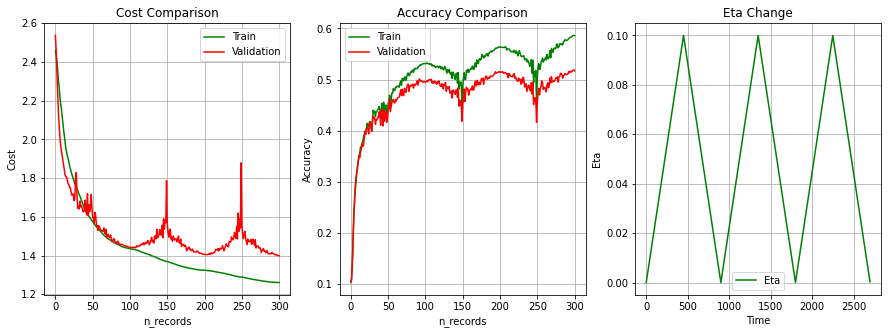

In [21]:
# In this functions, we didn't calculate the cost for each batch but 
# we calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes 2 minutes 3 seconds!
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 200, 3, lambda_coarse, 100, 50, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

In [22]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.5051


batch_size: 100, lambda_cost : 3.544673306817798e-05, d: 3072, m: 10, K: 10

total_batch: 450, n_steps : 900, n_epochs: 12, n_records: 5400

record_per_cycle: 100, cost_record : 301, comparison_number: 18

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:19:48.940423
J_train: 2.442802876413294 ... smooth_cost : 2.442802876413294 ... J_validation: 2.450656385587126

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:19:49.257452
J_train: 2.195285645654795 ... smooth_cost : 2.3190442610340445 ... J_validation: 2.3301931017965916

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:19:49.574954
J_train: 2.1391404623806674 ... smooth_cost : 2.2590763281495856 ... J_validation: 2.2347616918038455

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20 

cycle_no: 0 ... eta: 0.0698919 ... time: 2020-08-20 00:19:59.882423
J_train: 1.4302684232554284 ... smooth_cost : 1.7630502200252502 ... J_validation: 1.8392565583320901

epoch: 1, batch: 197, n_records: 647, cycle_step: 647
cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:20:00.200512
J_train: 1.542850594592061 ... smooth_cost : 1.7570988787973263 ... J_validation: 1.8299652973934757

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:20:00.509872
J_train: 1.4446182559814253 ... smooth_cost : 1.7488757045126972 ... J_validation: 1.7989526778692162

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:20:00.821947
J_train: 1.3028693780158347 ... smooth_cost : 1.7374396448589313 ... J_validation: 1.8168310891211945

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:20:01.131919
J_train: 1.537349548006

cycle_no: 0 ... eta: 0.0581153 ... time: 2020-08-20 00:20:10.982311
J_train: 1.5858854511024674 ... smooth_cost : 1.6303377976094369 ... J_validation: 1.7180502559513495

epoch: 2, batch: 395, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:20:11.284848
J_train: 1.4306206098915804 ... smooth_cost : 1.627601945722891 ... J_validation: 1.705862782325771

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:20:11.590751
J_train: 1.5125292659593816 ... smooth_cost : 1.6260469095098706 ... J_validation: 1.706664507421327

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:20:11.903148
J_train: 1.4270109635356392 ... smooth_cost : 1.6233930968968808 ... J_validation: 1.7031653410515546

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:20:12.202711
J_trai

cycle_no: 1 ... eta: 0.013897500000000002 ... time: 2020-08-20 00:20:21.976328
J_train: 1.558495084573337 ... smooth_cost : 1.6019973327943353 ... J_validation: 1.6677056211199983

epoch: 4, batch: 143, n_records: 1943, cycle_step: 143
cycle_no: 1 ... eta: 0.0158973 ... time: 2020-08-20 00:20:22.278109
J_train: 1.6673428316251107 ... smooth_cost : 1.6025968327836086 ... J_validation: 1.6711678847619011

epoch: 4, batch: 161, n_records: 1961, cycle_step: 161
cycle_no: 1 ... eta: 0.0178971 ... time: 2020-08-20 00:20:22.582242
J_train: 1.530449571452639 ... smooth_cost : 1.6019409485896907 ... J_validation: 1.6758144665312467

epoch: 4, batch: 179, n_records: 1979, cycle_step: 179
cycle_no: 1 ... eta: 0.019896900000000002 ... time: 2020-08-20 00:20:22.886882
J_train: 1.4457116979603923 ... smooth_cost : 1.6005334778633007 ... J_validation: 1.6728338446352777

epoch: 4, batch: 197, n_records: 1997, cycle_step: 197
cycle_no: 1 ... eta: 0.0218967 ... time: 2020-08-20 00:20:23.192732
J_train:

cycle_no: 1 ... eta: 0.0858903 ... time: 2020-08-20 00:20:33.022472
J_train: 1.33134164093896 ... smooth_cost : 1.567130391710549 ... J_validation: 1.7728225455545947

epoch: 5, batch: 341, n_records: 2591, cycle_step: 791
cycle_no: 1 ... eta: 0.08789010000000001 ... time: 2020-08-20 00:20:33.326844
J_train: 1.2821410178914636 ... smooth_cost : 1.565164947753176 ... J_validation: 1.7222977242881403

epoch: 5, batch: 359, n_records: 2609, cycle_step: 809
cycle_no: 1 ... eta: 0.0898899 ... time: 2020-08-20 00:20:33.633250
J_train: 1.601054835133171 ... smooth_cost : 1.5654107688996144 ... J_validation: 1.735489137064959

epoch: 5, batch: 377, n_records: 2627, cycle_step: 827
cycle_no: 1 ... eta: 0.0918897 ... time: 2020-08-20 00:20:33.939910
J_train: 1.4682077518137038 ... smooth_cost : 1.5647495238854245 ... J_validation: 1.7228142323918643

epoch: 5, batch: 395, n_records: 2645, cycle_step: 845
cycle_no: 1 ... eta: 0.0938895 ... time: 2020-08-20 00:20:34.249398
J_train: 1.3652152745563

cycle_no: 1 ... eta: 0.0421169 ... time: 2020-08-20 00:20:44.090974
J_train: 1.396418255548104 ... smooth_cost : 1.5393300502033918 ... J_validation: 1.6890365276133086

epoch: 7, batch: 89, n_records: 3239, cycle_step: 1439
cycle_no: 1 ... eta: 0.040117099999999996 ... time: 2020-08-20 00:20:44.395869
J_train: 1.7643331734884156 ... smooth_cost : 1.540573161381762 ... J_validation: 1.6722869975929278

epoch: 7, batch: 107, n_records: 3257, cycle_step: 1457
cycle_no: 1 ... eta: 0.03811729999999999 ... time: 2020-08-20 00:20:44.701701
J_train: 1.3575237532244635 ... smooth_cost : 1.539567395402876 ... J_validation: 1.6889026899486959

epoch: 7, batch: 125, n_records: 3275, cycle_step: 1475
cycle_no: 1 ... eta: 0.03611750000000001 ... time: 2020-08-20 00:20:45.006388
J_train: 1.5439192124173848 ... smooth_cost : 1.5395911758237202 ... J_validation: 1.6754500301362392

epoch: 7, batch: 143, n_records: 3293, cycle_step: 1493
cycle_no: 1 ... eta: 0.0341177 ... time: 2020-08-20 00:20:45.3186

cycle_no: 2 ... eta: 0.0298959 ... time: 2020-08-20 00:20:55.194550
J_train: 1.510827880468263 ... smooth_cost : 1.5350745506831955 ... J_validation: 1.6915041091626595

epoch: 8, batch: 287, n_records: 3887, cycle_step: 287
cycle_no: 2 ... eta: 0.031895700000000006 ... time: 2020-08-20 00:20:55.508605
J_train: 1.5294726864794466 ... smooth_cost : 1.5350487356407818 ... J_validation: 1.6899722644085

epoch: 8, batch: 305, n_records: 3905, cycle_step: 305
cycle_no: 2 ... eta: 0.03389550000000001 ... time: 2020-08-20 00:20:55.814644
J_train: 1.5073619782311733 ... smooth_cost : 1.534921732166426 ... J_validation: 1.6832661272849727

epoch: 8, batch: 323, n_records: 3923, cycle_step: 323
cycle_no: 2 ... eta: 0.035895300000000005 ... time: 2020-08-20 00:20:56.130588
J_train: 1.4239165908655276 ... smooth_cost : 1.5344148593750977 ... J_validation: 1.7123806403775421

epoch: 8, batch: 341, n_records: 3941, cycle_step: 341
cycle_no: 2 ... eta: 0.03789510000000001 ... time: 2020-08-20 00:20:5

cycle_no: 2 ... eta: 0.09811130000000001 ... time: 2020-08-20 00:21:06.246222
J_train: 1.4949662801094508 ... smooth_cost : 1.5182256965709269 ... J_validation: 1.7176758755354553

epoch: 10, batch: 35, n_records: 4535, cycle_step: 935
cycle_no: 2 ... eta: 0.0961115 ... time: 2020-08-20 00:21:06.553747
J_train: 1.3101972111665274 ... smooth_cost : 1.517403449593044 ... J_validation: 1.730639118327466

epoch: 10, batch: 53, n_records: 4553, cycle_step: 953
cycle_no: 2 ... eta: 0.0941117 ... time: 2020-08-20 00:21:06.854886
J_train: 1.3006595741709475 ... smooth_cost : 1.5165501272488624 ... J_validation: 1.7564349895412985

epoch: 10, batch: 71, n_records: 4571, cycle_step: 971
cycle_no: 2 ... eta: 0.09211190000000001 ... time: 2020-08-20 00:21:07.159562
J_train: 1.3343769753662877 ... smooth_cost : 1.5158357227316759 ... J_validation: 1.7119245775563958

epoch: 10, batch: 89, n_records: 4589, cycle_step: 989
cycle_no: 2 ... eta: 0.0901121 ... time: 2020-08-20 00:21:07.468813
J_train: 1

cycle_no: 2 ... eta: 0.02611849999999999 ... time: 2020-08-20 00:21:17.418087
J_train: 1.4037532306004954 ... smooth_cost : 1.5067866947175557 ... J_validation: 1.6644969452973242

epoch: 11, batch: 233, n_records: 5183, cycle_step: 1583
cycle_no: 2 ... eta: 0.024118700000000007 ... time: 2020-08-20 00:21:17.726166
J_train: 1.3334152119428349 ... smooth_cost : 1.5061867933930757 ... J_validation: 1.6687045986303883

epoch: 11, batch: 251, n_records: 5201, cycle_step: 1601
cycle_no: 2 ... eta: 0.022118899999999997 ... time: 2020-08-20 00:21:18.030805
J_train: 1.477277709003034 ... smooth_cost : 1.506087106895179 ... J_validation: 1.6656747801783407

epoch: 11, batch: 269, n_records: 5219, cycle_step: 1619
cycle_no: 2 ... eta: 0.0201191 ... time: 2020-08-20 00:21:18.338126
J_train: 1.5427377628845909 ... smooth_cost : 1.5062130541666203 ... J_validation: 1.6729066546166016

epoch: 11, batch: 287, n_records: 5237, cycle_step: 1637
cycle_no: 2 ... eta: 0.01811929999999999 ... time: 2020-08

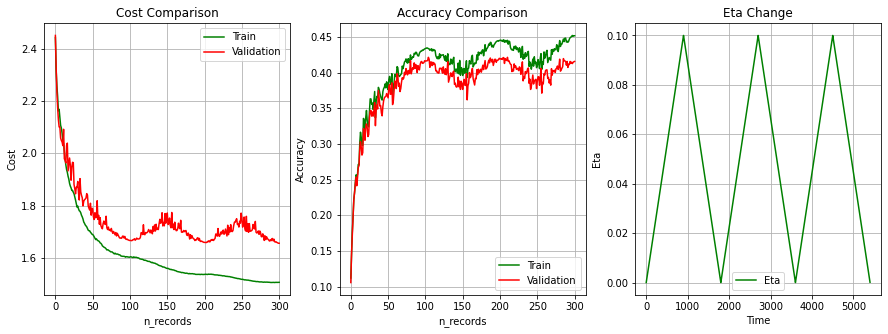

In [23]:
# In this function, we didn't calculate the cost for each batch but 
# we calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes 1 minute 34 seconds!  >> HERE we DECREASED the number of HIDDEN NODES from 50 to 10
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, lambda_coarse, 100, 10, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

In [24]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.4141


batch_size: 100, lambda_cost : 3.544673306817798e-05, d: 3072, m: 100, K: 10

total_batch: 450, n_steps : 900, n_epochs: 12, n_records: 5400

record_per_cycle: 100, cost_record : 301, comparison_number: 18

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:23:36.752962
J_train: 2.5821204437441163 ... smooth_cost : 2.5821204437441163 ... J_validation: 2.585023134975286

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:23:37.287236
J_train: 2.3759895321223716 ... smooth_cost : 2.479054987933244 ... J_validation: 2.4379698495623017

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:23:37.867743
J_train: 2.168886678588526 ... smooth_cost : 2.375665551485005 ... J_validation: 2.2529580241751304

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20

cycle_no: 0 ... eta: 0.0698919 ... time: 2020-08-20 00:23:56.387339
J_train: 1.1287782132050521 ... smooth_cost : 1.4674206248243022 ... J_validation: 1.6887949902221129

epoch: 1, batch: 197, n_records: 647, cycle_step: 647
cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:23:56.959946
J_train: 1.1995057661756396 ... smooth_cost : 1.4601796826986626 ... J_validation: 1.615506945333836

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:23:57.528972
J_train: 1.06460868163293 ... smooth_cost : 1.4497699195127225 ... J_validation: 1.5967741323352593

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:23:58.099771
J_train: 0.9184863263434692 ... smooth_cost : 1.4361472632776133 ... J_validation: 1.6040879158571641

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:23:58.670881
J_train: 1.07660492170336

cycle_no: 0 ... eta: 0.0581153 ... time: 2020-08-20 00:24:17.229229
J_train: 1.1667098847408932 ... smooth_cost : 1.2663492981565003 ... J_validation: 1.4932616896559425

epoch: 2, batch: 395, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:24:17.813987
J_train: 1.0116852778427323 ... smooth_cost : 1.262860749933024 ... J_validation: 1.481927667768112

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:24:18.389983
J_train: 1.0484350897823729 ... smooth_cost : 1.259963105876934 ... J_validation: 1.4774146635042535

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:24:18.964581
J_train: 0.916039198371506 ... smooth_cost : 1.2553774537768618 ... J_validation: 1.4999476659781834

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:24:19.546247
J_train

cycle_no: 1 ... eta: 0.013897500000000002 ... time: 2020-08-20 00:24:38.200548
J_train: 1.1912908978888161 ... smooth_cost : 1.2199904050611212 ... J_validation: 1.3899989585750638

epoch: 4, batch: 143, n_records: 1943, cycle_step: 143
cycle_no: 1 ... eta: 0.0158973 ... time: 2020-08-20 00:24:38.789526
J_train: 1.2848398668442298 ... smooth_cost : 1.2205853542517922 ... J_validation: 1.402007625712735

epoch: 4, batch: 161, n_records: 1961, cycle_step: 161
cycle_no: 1 ... eta: 0.0178971 ... time: 2020-08-20 00:24:39.377746
J_train: 1.0014529189814554 ... smooth_cost : 1.2185932412038798 ... J_validation: 1.4029230430437756

epoch: 4, batch: 179, n_records: 1979, cycle_step: 179
cycle_no: 1 ... eta: 0.019896900000000002 ... time: 2020-08-20 00:24:40.000043
J_train: 1.0275538881586976 ... smooth_cost : 1.2168721659512205 ... J_validation: 1.3997627717433347

epoch: 4, batch: 197, n_records: 1997, cycle_step: 197
cycle_no: 1 ... eta: 0.0218967 ... time: 2020-08-20 00:24:40.594536
J_train

cycle_no: 1 ... eta: 0.0858903 ... time: 2020-08-20 00:24:59.664737
J_train: 0.9110973978888315 ... smooth_cost : 1.1531030376692144 ... J_validation: 1.7398507233608491

epoch: 5, batch: 341, n_records: 2591, cycle_step: 791
cycle_no: 1 ... eta: 0.08789010000000001 ... time: 2020-08-20 00:25:00.255548
J_train: 0.675309167498096 ... smooth_cost : 1.1498079075301033 ... J_validation: 1.5541840420150357

epoch: 5, batch: 359, n_records: 2609, cycle_step: 809
cycle_no: 1 ... eta: 0.0898899 ... time: 2020-08-20 00:25:00.851587
J_train: 0.908508867691368 ... smooth_cost : 1.148155174380523 ... J_validation: 1.5873690085328067

epoch: 5, batch: 377, n_records: 2627, cycle_step: 827
cycle_no: 1 ... eta: 0.0918897 ... time: 2020-08-20 00:25:01.442245
J_train: 0.9846300789734386 ... smooth_cost : 1.1470427587655088 ... J_validation: 1.5614177734878791

epoch: 5, batch: 395, n_records: 2645, cycle_step: 845
cycle_no: 1 ... eta: 0.0938895 ... time: 2020-08-20 00:25:02.038636
J_train: 0.8231871414

cycle_no: 1 ... eta: 0.0421169 ... time: 2020-08-20 00:25:25.141834
J_train: 0.7650249430048973 ... smooth_cost : 1.0993956256291906 ... J_validation: 1.4476291729853346

epoch: 7, batch: 89, n_records: 3239, cycle_step: 1439
cycle_no: 1 ... eta: 0.040117099999999996 ... time: 2020-08-20 00:25:25.767470
J_train: 1.1827176950106897 ... smooth_cost : 1.0998559685539504 ... J_validation: 1.4292764197971508

epoch: 7, batch: 107, n_records: 3257, cycle_step: 1457
cycle_no: 1 ... eta: 0.03811729999999999 ... time: 2020-08-20 00:25:26.373198
J_train: 0.815188744451295 ... smooth_cost : 1.0982918629270126 ... J_validation: 1.4355924154079016

epoch: 7, batch: 125, n_records: 3275, cycle_step: 1475
cycle_no: 1 ... eta: 0.03611750000000001 ... time: 2020-08-20 00:25:26.977469
J_train: 0.9990142907499283 ... smooth_cost : 1.0977493625326022 ... J_validation: 1.4337870707262406

epoch: 7, batch: 143, n_records: 3293, cycle_step: 1493
cycle_no: 1 ... eta: 0.0341177 ... time: 2020-08-20 00:25:27.58

cycle_no: 2 ... eta: 0.0298959 ... time: 2020-08-20 00:25:47.958131
J_train: 0.8472214441933649 ... smooth_cost : 1.0820417036474548 ... J_validation: 1.4410297567277215

epoch: 8, batch: 287, n_records: 3887, cycle_step: 287
cycle_no: 2 ... eta: 0.031895700000000006 ... time: 2020-08-20 00:25:48.556591
J_train: 0.9619711870481037 ... smooth_cost : 1.0814883832944624 ... J_validation: 1.4427649280633383

epoch: 8, batch: 305, n_records: 3905, cycle_step: 305
cycle_no: 2 ... eta: 0.03389550000000001 ... time: 2020-08-20 00:25:49.168214
J_train: 0.8683098187290873 ... smooth_cost : 1.080510499970768 ... J_validation: 1.4441999668246515

epoch: 8, batch: 323, n_records: 3923, cycle_step: 323
cycle_no: 2 ... eta: 0.035895300000000005 ... time: 2020-08-20 00:25:49.768942
J_train: 0.7934608626288404 ... smooth_cost : 1.0791997710331336 ... J_validation: 1.479510795575166

epoch: 8, batch: 341, n_records: 3941, cycle_step: 341
cycle_no: 2 ... eta: 0.03789510000000001 ... time: 2020-08-20 00:2

cycle_no: 2 ... eta: 0.09811130000000001 ... time: 2020-08-20 00:26:10.050392
J_train: 0.9562068830937503 ... smooth_cost : 1.043553872184258 ... J_validation: 1.6805504574987389

epoch: 10, batch: 35, n_records: 4535, cycle_step: 935
cycle_no: 2 ... eta: 0.0961115 ... time: 2020-08-20 00:26:10.669734
J_train: 1.0283879808846852 ... smooth_cost : 1.0434939279498725 ... J_validation: 1.7988008393971864

epoch: 10, batch: 53, n_records: 4553, cycle_step: 953
cycle_no: 2 ... eta: 0.0941117 ... time: 2020-08-20 00:26:11.284352
J_train: 0.6730478213834804 ... smooth_cost : 1.042035478711422 ... J_validation: 1.7093324615935697

epoch: 10, batch: 71, n_records: 4571, cycle_step: 971
cycle_no: 2 ... eta: 0.09211190000000001 ... time: 2020-08-20 00:26:11.879192
J_train: 0.7582195637298944 ... smooth_cost : 1.040922475123259 ... J_validation: 1.604903911520308

epoch: 10, batch: 89, n_records: 4589, cycle_step: 989
cycle_no: 2 ... eta: 0.0901121 ... time: 2020-08-20 00:26:12.467774
J_train: 1.0

cycle_no: 2 ... eta: 0.02611849999999999 ... time: 2020-08-20 00:26:31.819187
J_train: 0.7620411928550984 ... smooth_cost : 1.0129346476641516 ... J_validation: 1.4240887519409815

epoch: 11, batch: 233, n_records: 5183, cycle_step: 1583
cycle_no: 2 ... eta: 0.024118700000000007 ... time: 2020-08-20 00:26:32.413934
J_train: 0.7022136573369587 ... smooth_cost : 1.0118594885280714 ... J_validation: 1.4115288018653864

epoch: 11, batch: 251, n_records: 5201, cycle_step: 1601
cycle_no: 2 ... eta: 0.022118899999999997 ... time: 2020-08-20 00:26:33.010832
J_train: 0.9531894662031054 ... smooth_cost : 1.0116571781062613 ... J_validation: 1.4306678186038118

epoch: 11, batch: 269, n_records: 5219, cycle_step: 1619
cycle_no: 2 ... eta: 0.0201191 ... time: 2020-08-20 00:26:33.600951
J_train: 0.8536619939261012 ... smooth_cost : 1.0111142393290098 ... J_validation: 1.4262997997209268

epoch: 11, batch: 287, n_records: 5237, cycle_step: 1637
cycle_no: 2 ... eta: 0.01811929999999999 ... time: 2020-

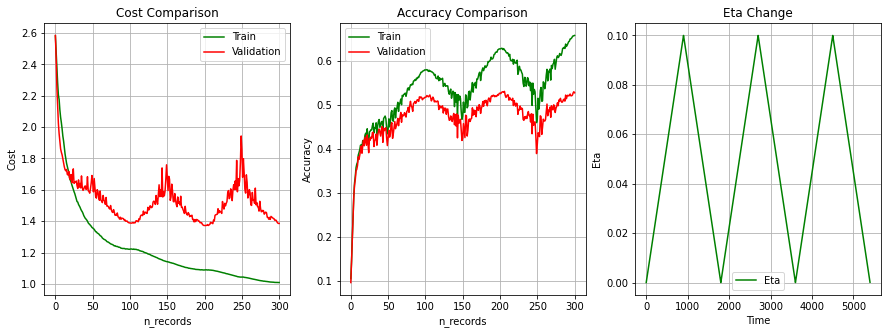

In [25]:
# In this function, we didn't calculate the cost for each batch but 
# we calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes arund 3 minutes! >> HERE we INCREASED the number of HIDDEN NODES from 50 to 100
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, lambda_coarse, 100, 100, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

In [26]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.5186


batch_size: 100, lambda_cost : 3.544673306817798e-05, d: 3072, m: 200, K: 10

total_batch: 450, n_steps : 900, n_epochs: 12, n_records: 5400

record_per_cycle: 100, cost_record : 301, comparison_number: 18

epoch: 0, batch: 0, n_records: 0, cycle_step: 0
cycle_no: 0 ... eta: 1e-05 ... time: 2020-08-20 00:29:25.360149
J_train: 2.5353538442607735 ... smooth_cost : 2.5353538442607735 ... J_validation: 2.5092641496045767

epoch: 0, batch: 17, n_records: 17, cycle_step: 17
cycle_no: 0 ... eta: 0.0018987000000000001 ... time: 2020-08-20 00:29:26.301121
J_train: 2.317149776677373 ... smooth_cost : 2.4262518104690733 ... J_validation: 2.394379597320168

epoch: 0, batch: 35, n_records: 35, cycle_step: 35
cycle_no: 0 ... eta: 0.0038985000000000005 ... time: 2020-08-20 00:29:27.256472
J_train: 2.049160488118562 ... smooth_cost : 2.300554703018903 ... J_validation: 2.2391238170511607

epoch: 0, batch: 53, n_records: 53, cycle_step: 53
cycle_no: 0 ... eta: 0.0058982999999999996 ... time: 2020-08-20

cycle_no: 0 ... eta: 0.0698919 ... time: 2020-08-20 00:30:00.000538
J_train: 1.060240099879641 ... smooth_cost : 1.4379861869949044 ... J_validation: 1.6528498750805372

epoch: 1, batch: 197, n_records: 647, cycle_step: 647
cycle_no: 0 ... eta: 0.0718917 ... time: 2020-08-20 00:30:01.045283
J_train: 1.1194834935226057 ... smooth_cost : 1.429378006090248 ... J_validation: 1.5932977323665998

epoch: 1, batch: 215, n_records: 665, cycle_step: 665
cycle_no: 0 ... eta: 0.07389150000000001 ... time: 2020-08-20 00:30:02.053693
J_train: 1.0088005041309858 ... smooth_cost : 1.41831017709132 ... J_validation: 1.553124231313239

epoch: 1, batch: 233, n_records: 683, cycle_step: 683
cycle_no: 0 ... eta: 0.0758913 ... time: 2020-08-20 00:30:03.061918
J_train: 0.8800341313554317 ... smooth_cost : 1.4045082272006562 ... J_validation: 1.546573764151956

epoch: 1, batch: 251, n_records: 701, cycle_step: 701
cycle_no: 0 ... eta: 0.0778911 ... time: 2020-08-20 00:30:04.051543
J_train: 1.0311707765525067 

cycle_no: 0 ... eta: 0.0581153 ... time: 2020-08-20 00:30:36.317534
J_train: 1.119026322938179 ... smooth_cost : 1.2265125499913165 ... J_validation: 1.4844697192102017

epoch: 2, batch: 395, n_records: 1295, cycle_step: 1295
cycle_no: 0 ... eta: 0.0561155 ... time: 2020-08-20 00:30:37.317739
J_train: 0.9600346938839179 ... smooth_cost : 1.222862168400804 ... J_validation: 1.4550577407564356

epoch: 2, batch: 413, n_records: 1313, cycle_step: 1313
cycle_no: 0 ... eta: 0.0541157 ... time: 2020-08-20 00:30:38.320384
J_train: 1.0035025433165605 ... smooth_cost : 1.2198978491429089 ... J_validation: 1.4519504676227473

epoch: 2, batch: 431, n_records: 1331, cycle_step: 1331
cycle_no: 0 ... eta: 0.05211590000000001 ... time: 2020-08-20 00:30:39.318169
J_train: 0.8409057909920302 ... smooth_cost : 1.214844621700897 ... J_validation: 1.471834497686687

epoch: 2, batch: 449, n_records: 1349, cycle_step: 1349
cycle_no: 0 ... eta: 0.050116100000000004 ... time: 2020-08-20 00:30:40.402595
J_train

cycle_no: 1 ... eta: 0.013897500000000002 ... time: 2020-08-20 00:31:17.595808
J_train: 1.0669979792398143 ... smooth_cost : 1.1732301940237373 ... J_validation: 1.3639220244576764

epoch: 4, batch: 143, n_records: 1943, cycle_step: 143
cycle_no: 1 ... eta: 0.0158973 ... time: 2020-08-20 00:31:18.700497
J_train: 1.224710655038828 ... smooth_cost : 1.1737024918312151 ... J_validation: 1.3750351962979228

epoch: 4, batch: 161, n_records: 1961, cycle_step: 161
cycle_no: 1 ... eta: 0.0178971 ... time: 2020-08-20 00:31:19.813867
J_train: 0.8763289608202081 ... smooth_cost : 1.1709990960947514 ... J_validation: 1.3813322535222925

epoch: 4, batch: 179, n_records: 1979, cycle_step: 179
cycle_no: 1 ... eta: 0.019896900000000002 ... time: 2020-08-20 00:31:20.950082
J_train: 0.9580696356444274 ... smooth_cost : 1.169080812667271 ... J_validation: 1.3738682003946328

epoch: 4, batch: 197, n_records: 1997, cycle_step: 197
cycle_no: 1 ... eta: 0.0218967 ... time: 2020-08-20 00:31:22.083592
J_train:

cycle_no: 1 ... eta: 0.0858903 ... time: 2020-08-20 00:31:57.858223
J_train: 0.8573574888211445 ... smooth_cost : 1.0959879241901804 ... J_validation: 1.7729319414484137

epoch: 5, batch: 341, n_records: 2591, cycle_step: 791
cycle_no: 1 ... eta: 0.08789010000000001 ... time: 2020-08-20 00:31:58.913491
J_train: 0.6476270506592217 ... smooth_cost : 1.0928957802347945 ... J_validation: 1.5949248996989491

epoch: 5, batch: 359, n_records: 2609, cycle_step: 809
cycle_no: 1 ... eta: 0.0898899 ... time: 2020-08-20 00:31:59.941217
J_train: 0.8990304669193651 ... smooth_cost : 1.0915679356230448 ... J_validation: 1.6117114784629005

epoch: 5, batch: 377, n_records: 2627, cycle_step: 827
cycle_no: 1 ... eta: 0.0918897 ... time: 2020-08-20 00:32:00.975213
J_train: 0.9623841996092634 ... smooth_cost : 1.090689134697781 ... J_validation: 1.6322193780235967

epoch: 5, batch: 395, n_records: 2645, cycle_step: 845
cycle_no: 1 ... eta: 0.0938895 ... time: 2020-08-20 00:32:01.983598
J_train: 0.82014400

cycle_no: 1 ... eta: 0.0421169 ... time: 2020-08-20 00:32:35.130517
J_train: 0.7137709259852298 ... smooth_cost : 1.0413427944387046 ... J_validation: 1.4467862700504637

epoch: 7, batch: 89, n_records: 3239, cycle_step: 1439
cycle_no: 1 ... eta: 0.040117099999999996 ... time: 2020-08-20 00:32:36.151681
J_train: 1.0428323505946338 ... smooth_cost : 1.0413510240307264 ... J_validation: 1.4168611837716272

epoch: 7, batch: 107, n_records: 3257, cycle_step: 1457
cycle_no: 1 ... eta: 0.03811729999999999 ... time: 2020-08-20 00:32:37.152907
J_train: 0.7127490123809007 ... smooth_cost : 1.0395455184722109 ... J_validation: 1.4266905496746156

epoch: 7, batch: 125, n_records: 3275, cycle_step: 1475
cycle_no: 1 ... eta: 0.03611750000000001 ... time: 2020-08-20 00:32:38.155893
J_train: 0.8526046793000269 ... smooth_cost : 1.0385239838319256 ... J_validation: 1.4055217108390232

epoch: 7, batch: 143, n_records: 3293, cycle_step: 1493
cycle_no: 1 ... eta: 0.0341177 ... time: 2020-08-20 00:32:39.1

cycle_no: 2 ... eta: 0.0298959 ... time: 2020-08-20 00:33:12.742170
J_train: 0.7676091034730841 ... smooth_cost : 1.0163917508472762 ... J_validation: 1.4281170330356552

epoch: 8, batch: 287, n_records: 3887, cycle_step: 287
cycle_no: 2 ... eta: 0.031895700000000006 ... time: 2020-08-20 00:33:13.795871
J_train: 0.815931303173115 ... smooth_cost : 1.0154679699824183 ... J_validation: 1.4221816421720745

epoch: 8, batch: 305, n_records: 3905, cycle_step: 305
cycle_no: 2 ... eta: 0.03389550000000001 ... time: 2020-08-20 00:33:14.850041
J_train: 0.7052220210678413 ... smooth_cost : 1.0140448234277641 ... J_validation: 1.41096586406836

epoch: 8, batch: 323, n_records: 3923, cycle_step: 323
cycle_no: 2 ... eta: 0.035895300000000005 ... time: 2020-08-20 00:33:15.974932
J_train: 0.7090620687235082 ... smooth_cost : 1.01265220810948 ... J_validation: 1.4834303853812394

epoch: 8, batch: 341, n_records: 3941, cycle_step: 341
cycle_no: 2 ... eta: 0.03789510000000001 ... time: 2020-08-20 00:33:1

cycle_no: 2 ... eta: 0.09811130000000001 ... time: 2020-08-20 00:33:50.247768
J_train: 0.9988908739946865 ... smooth_cost : 0.9755394989001769 ... J_validation: 1.7963486289098844

epoch: 10, batch: 35, n_records: 4535, cycle_step: 935
cycle_no: 2 ... eta: 0.0961115 ... time: 2020-08-20 00:33:51.304622
J_train: 1.097188441560486 ... smooth_cost : 0.9760203247604944 ... J_validation: 2.0340153518089874

epoch: 10, batch: 53, n_records: 4553, cycle_step: 953
cycle_no: 2 ... eta: 0.0941117 ... time: 2020-08-20 00:33:52.341368
J_train: 0.5386783027901184 ... smooth_cost : 0.974298505776359 ... J_validation: 1.7045056129173641

epoch: 10, batch: 71, n_records: 4571, cycle_step: 971
cycle_no: 2 ... eta: 0.09211190000000001 ... time: 2020-08-20 00:33:53.375056
J_train: 0.6415348423627795 ... smooth_cost : 0.9729935502335606 ... J_validation: 1.6364061278387838

epoch: 10, batch: 89, n_records: 4589, cycle_step: 989
cycle_no: 2 ... eta: 0.0901121 ... time: 2020-08-20 00:33:54.379509
J_train: 0

cycle_no: 2 ... eta: 0.02611849999999999 ... time: 2020-08-20 00:34:27.405645
J_train: 0.6880056916660818 ... smooth_cost : 0.939873135421998 ... J_validation: 1.4180443982478306

epoch: 11, batch: 233, n_records: 5183, cycle_step: 1583
cycle_no: 2 ... eta: 0.024118700000000007 ... time: 2020-08-20 00:34:28.409818
J_train: 0.6080649424497044 ... smooth_cost : 0.9387250101867997 ... J_validation: 1.4098517648222688

epoch: 11, batch: 251, n_records: 5201, cycle_step: 1601
cycle_no: 2 ... eta: 0.022118899999999997 ... time: 2020-08-20 00:34:29.410621
J_train: 0.787645135252534 ... smooth_cost : 0.9382040451008195 ... J_validation: 1.423655165843039

epoch: 11, batch: 269, n_records: 5219, cycle_step: 1619
cycle_no: 2 ... eta: 0.0201191 ... time: 2020-08-20 00:34:30.420263
J_train: 0.7577942980271423 ... smooth_cost : 0.9375840803342432 ... J_validation: 1.4112307026037059

epoch: 11, batch: 287, n_records: 5237, cycle_step: 1637
cycle_no: 2 ... eta: 0.01811929999999999 ... time: 2020-08-

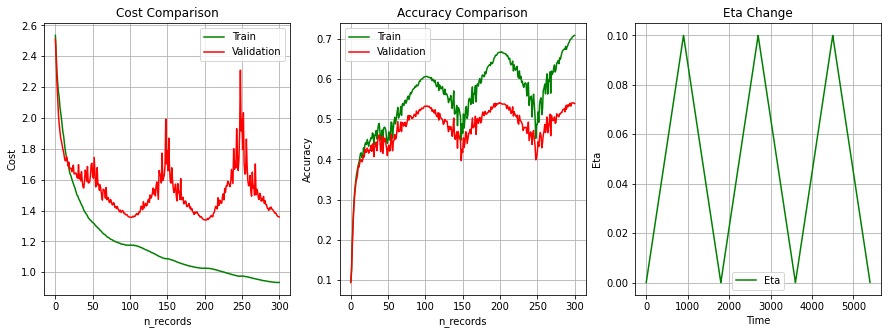

In [27]:
# In this function, we didn't calculate the cost for each batch but 
# we calculated it for 100 batches out of 1800 in 1 cycle
# and this helped me to save a lot of time with a similar result with the one I calculated J for each batch
# takes arund 3 minutes! >> HERE we INCREASED the number of HIDDEN NODES from 50 to 100
lambda_coarse = 3.544673306817798e-05  #1.8544671883635666e-05
# N_CYCLEs changed >> from 1 to 3
# param_list = [network1, train_X_Norm, validation_X_Norm, batch_size, n_cycles, lambda_cost, record_per_cycle, m, 
#               eta_min, eta_max]

param_list = [network1, train_X_Norm, validation_X_Norm, 100, 3, lambda_coarse, 100, 200, 1e-5, 1e-1]
layers, W, b, eta_train = Train_Cyclical_Coarse_lambda_smooth_aggregated_2(param_list)

In [28]:
P_test, H_test = network1.EvaluationClassifier(layers, test_X_Norm, W, b)
k_test = np.argmax(P_test, axis=0)
A_test = network1.ComputeAccuracy(k_test, network1.test_y)
print(A_test)

0.5336
